In [12]:
# add per chromosome SHAP
# Use this notebook for widget: https://github.com/coryroyce/shap/blob/master/notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.ipynb

In [1]:
import os
import sys
sys.path.append("../src/")
from model import DLMLP, DLPerChromosome, DLPerGene, SklearnPerChromosome, SklearnPerGene, SklearnLinear

import json
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from ast import literal_eval
import plotly.graph_objects as go
from typing import Any, Dict, List, Tuple
from pprint import pprint

import joblib
import torch
import shap
shap.initjs()
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [2]:
processed_data_dir = "/cluster/scratch/aarslan/cna2zscore_data/processed/"
checkpoints_dir = "/cluster/scratch/aarslan/cna2zscore_checkpoints/"

rppa2zscore_test_sample_ids = ['TCGA-04-1348-01', 'TCGA-04-1514-01', 'TCGA-04-1519-01', 'TCGA-05-4397-01', 'TCGA-05-4410-01', 'TCGA-05-4426-01', 'TCGA-06-0125-01', 'TCGA-06-0190-01', 'TCGA-06-0238-01', 'TCGA-06-0878-01', 'TCGA-06-5415-01', 'TCGA-06-5858-01', 'TCGA-06-5859-01', 'TCGA-08-0386-01', 'TCGA-09-2044-01', 'TCGA-09-2045-01', 'TCGA-13-0799-01', 'TCGA-13-0801-01', 'TCGA-13-1405-01', 'TCGA-13-1411-01', 'TCGA-19-1390-01', 'TCGA-21-1072-01', 'TCGA-21-1078-01', 'TCGA-21-5782-01', 'TCGA-21-5786-01', 'TCGA-22-5479-01', 'TCGA-23-1109-01', 'TCGA-23-1809-01', 'TCGA-23-2078-01', 'TCGA-23-2081-01', 'TCGA-24-1423-01', 'TCGA-24-1469-01', 'TCGA-24-1553-01', 'TCGA-24-1557-01', 'TCGA-24-1558-01', 'TCGA-24-1567-01', 'TCGA-24-1850-01', 'TCGA-24-1924-01', 'TCGA-24-2027-01', 'TCGA-24-2254-01', 'TCGA-24-2289-01', 'TCGA-24-2290-01', 'TCGA-25-1312-01', 'TCGA-25-1314-01', 'TCGA-25-1631-01', 'TCGA-25-1632-01', 'TCGA-29-1693-01', 'TCGA-29-1697-01', 'TCGA-29-1701-01', 'TCGA-29-1710-01', 'TCGA-29-1781-01', 'TCGA-2A-A8VT-01', 'TCGA-2A-A8VV-01', 'TCGA-2H-A9GL-01', 'TCGA-2L-AAQM-01', 'TCGA-2Z-A9J5-01', 'TCGA-2Z-A9JE-01', 'TCGA-2Z-A9JJ-01', 'TCGA-30-1861-01', 'TCGA-31-1951-01', 'TCGA-33-4582-01', 'TCGA-33-AASB-01', 'TCGA-33-AASD-01', 'TCGA-33-AASI-01', 'TCGA-34-2608-01', 'TCGA-34-5239-01', 'TCGA-34-7107-01', 'TCGA-36-1571-01', 'TCGA-36-1575-01', 'TCGA-37-4141-01', 'TCGA-38-6178-01', 'TCGA-39-5016-01', 'TCGA-39-5027-01', 'TCGA-39-5029-01', 'TCGA-39-5034-01', 'TCGA-3A-A9IN-01', 'TCGA-3B-A9HJ-01', 'TCGA-3E-AAAZ-01', 'TCGA-3G-AB0O-01', 'TCGA-3H-AB3U-01', 'TCGA-3S-AAYX-01', 'TCGA-3U-A98D-01', 'TCGA-3U-A98J-01', 'TCGA-41-3915-01', 'TCGA-43-2578-01', 'TCGA-43-2581-01', 'TCGA-43-6770-01', 'TCGA-43-6771-01', 'TCGA-43-A474-01', 'TCGA-43-A475-01', 'TCGA-44-3398-01', 'TCGA-44-4112-01', 'TCGA-44-5644-01', 'TCGA-44-6147-01', 'TCGA-44-6775-01', 'TCGA-44-7662-01', 'TCGA-44-A4SS-01', 'TCGA-46-6026-01', 'TCGA-49-4487-01', 'TCGA-49-4512-01', 'TCGA-49-4514-01', 'TCGA-49-AARE-01', 'TCGA-4A-A93Y-01', 'TCGA-4N-A93T-01', 'TCGA-4V-A9QL-01', 'TCGA-4V-A9QX-01', 'TCGA-4X-A9FB-01', 'TCGA-4Z-AA80-01', 'TCGA-4Z-AA81-01', 'TCGA-4Z-AA84-01', 'TCGA-50-5044-01', 'TCGA-50-5072-01', 'TCGA-50-5936-01', 'TCGA-50-5939-01', 'TCGA-50-5944-01', 'TCGA-50-6595-01', 'TCGA-50-8457-01', 'TCGA-50-8459-01', 'TCGA-52-7810-01', 'TCGA-55-1592-01', 'TCGA-55-6543-01', 'TCGA-55-7573-01', 'TCGA-55-7728-01', 'TCGA-55-7910-01', 'TCGA-55-8505-01', 'TCGA-56-5898-01', 'TCGA-56-8083-01', 'TCGA-56-8309-01', 'TCGA-56-A5DS-01', 'TCGA-59-2363-01', 'TCGA-5M-AAT6-01', 'TCGA-5N-A9KI-01', 'TCGA-5U-AB0E-01', 'TCGA-5V-A9RR-01', 'TCGA-60-2697-01', 'TCGA-60-2703-01', 'TCGA-61-1740-01', 'TCGA-61-1741-01', 'TCGA-61-1914-01', 'TCGA-61-2101-01', 'TCGA-61-2102-01', 'TCGA-61-2113-01', 'TCGA-62-8398-01', 'TCGA-62-A46S-01', 'TCGA-63-6202-01', 'TCGA-63-7020-01', 'TCGA-63-7021-01', 'TCGA-63-7022-01', 'TCGA-63-A5MB-01', 'TCGA-63-A5MG-01', 'TCGA-63-A5MT-01', 'TCGA-64-1680-01', 'TCGA-64-5774-01', 'TCGA-66-2727-01', 'TCGA-66-2778-01', 'TCGA-66-2790-01', 'TCGA-67-3771-01', 'TCGA-69-7760-01', 'TCGA-69-7764-01', 'TCGA-70-6722-01', 'TCGA-73-4658-01', 'TCGA-73-4670-01', 'TCGA-73-4675-01', 'TCGA-73-4676-01', 'TCGA-75-5122-01', 'TCGA-75-6206-01', 'TCGA-75-6212-01', 'TCGA-76-4926-01', 'TCGA-76-4929-01', 'TCGA-77-7141-01', 'TCGA-77-8154-01', 'TCGA-78-7150-01', 'TCGA-78-7154-01', 'TCGA-78-7162-01', 'TCGA-78-7163-01', 'TCGA-78-7167-01', 'TCGA-78-7536-01', 'TCGA-78-7542-01', 'TCGA-78-8662-01', 'TCGA-85-6560-01', 'TCGA-85-7696-01', 'TCGA-85-7844-01', 'TCGA-85-8072-01', 'TCGA-85-8350-01', 'TCGA-85-8479-01', 'TCGA-85-A4PA-01', 'TCGA-85-A4QR-01', 'TCGA-85-A513-01', 'TCGA-86-8054-01', 'TCGA-86-8669-01', 'TCGA-86-A4JF-01', 'TCGA-90-A59Q-01', 'TCGA-91-6828-01', 'TCGA-91-6848-01', 'TCGA-91-A4BD-01', 'TCGA-92-7340-01', 'TCGA-93-A4JN-01', 'TCGA-94-A4VJ-01', 'TCGA-94-A5I4-01', 'TCGA-94-A5I6-01', 'TCGA-95-A4VK-01', 'TCGA-97-7552-01', 'TCGA-97-7941-01', 'TCGA-97-A4M2-01', 'TCGA-98-7454-01', 'TCGA-98-A539-01', 'TCGA-98-A53C-01', 'TCGA-99-8028-01', 'TCGA-A1-A0SF-01', 'TCGA-A2-A04U-01', 'TCGA-A2-A04W-01', 'TCGA-A2-A0CK-01', 'TCGA-A2-A0CQ-01', 'TCGA-A2-A0CX-01', 'TCGA-A2-A0D4-01', 'TCGA-A2-A0EO-01', 'TCGA-A2-A0EQ-01', 'TCGA-A2-A0ES-01', 'TCGA-A2-A0EW-01', 'TCGA-A2-A0T0-01', 'TCGA-A2-A0T3-01', 'TCGA-A2-A0YC-01', 'TCGA-A2-A1FW-01', 'TCGA-A2-A1FZ-01', 'TCGA-A2-A3KC-01', 'TCGA-A3-3322-01', 'TCGA-A3-3347-01', 'TCGA-A3-3365-01', 'TCGA-A3-3367-01', 'TCGA-A3-3382-01', 'TCGA-A4-7584-01', 'TCGA-A4-7734-01', 'TCGA-A4-7915-01', 'TCGA-A4-8098-01', 'TCGA-A4-8311-01', 'TCGA-A4-8630-01', 'TCGA-A5-A0G5-01', 'TCGA-A5-A0GB-01', 'TCGA-A5-A0GM-01', 'TCGA-A5-A0GN-01', 'TCGA-A5-A0R9-01', 'TCGA-A5-A0RA-01', 'TCGA-A5-A1OH-01', 'TCGA-A6-6138-01', 'TCGA-A7-A0CD-01', 'TCGA-A7-A13F-01', 'TCGA-A7-A26E-01', 'TCGA-A7-A4SE-01', 'TCGA-A8-A06P-01', 'TCGA-A8-A06R-01', 'TCGA-A8-A06U-01', 'TCGA-A8-A06Z-01', 'TCGA-A8-A075-01', 'TCGA-A8-A07E-01', 'TCGA-A8-A07W-01', 'TCGA-A8-A086-01', 'TCGA-A8-A08O-01', 'TCGA-A8-A08T-01', 'TCGA-A8-A091-01', 'TCGA-AA-3510-01', 'TCGA-AA-3520-01', 'TCGA-AA-3525-01', 'TCGA-AA-3529-01', 'TCGA-AA-3531-01', 'TCGA-AA-3688-01', 'TCGA-AA-3697-01', 'TCGA-AA-3710-01', 'TCGA-AA-3811-01', 'TCGA-AA-3831-01', 'TCGA-AA-3833-01', 'TCGA-AA-3837-01', 'TCGA-AA-3848-01', 'TCGA-AA-3854-01', 'TCGA-AA-3955-01', 'TCGA-AA-3986-01', 'TCGA-AA-A00F-01', 'TCGA-AA-A017-01', 'TCGA-AA-A01D-01', 'TCGA-AC-A23C-01', 'TCGA-AC-A2QJ-01', 'TCGA-AC-A3QP-01', 'TCGA-AC-A3TM-01', 'TCGA-AC-A3TN-01', 'TCGA-AC-A3W6-01', 'TCGA-AC-A3W7-01', 'TCGA-AC-A4ZE-01', 'TCGA-AC-A62X-01', 'TCGA-AC-A6IX-01', 'TCGA-AD-6889-01', 'TCGA-AF-2690-01', 'TCGA-AG-3574-01', 'TCGA-AG-3578-01', 'TCGA-AG-3581-01', 'TCGA-AG-3598-01', 'TCGA-AG-3742-01', 'TCGA-AG-3881-01', 'TCGA-AG-3882-01', 'TCGA-AG-3896-01', 'TCGA-AG-3898-01', 'TCGA-AG-3901-01', 'TCGA-AG-4001-01', 'TCGA-AG-A015-01', 'TCGA-AJ-A23M-01', 'TCGA-AJ-A2QK-01', 'TCGA-AK-3427-01', 'TCGA-AK-3456-01', 'TCGA-AN-A0AR-01', 'TCGA-AN-A0FL-01', 'TCGA-AN-A0FS-01', 'TCGA-AN-A0FT-01', 'TCGA-AN-A0FW-01', 'TCGA-AN-A0FX-01', 'TCGA-AO-A03L-01', 'TCGA-AO-A03M-01', 'TCGA-AO-A03N-01', 'TCGA-AO-A03P-01', 'TCGA-AO-A03U-01', 'TCGA-AO-A0J6-01', 'TCGA-AO-A0J8-01', 'TCGA-AO-A0JF-01', 'TCGA-AO-A0JL-01', 'TCGA-AO-A124-01', 'TCGA-AO-A12A-01', 'TCGA-AO-A12B-01', 'TCGA-AO-A12H-01', 'TCGA-AO-A1KQ-01', 'TCGA-AO-A1KT-01', 'TCGA-AP-A054-01', 'TCGA-AP-A056-01', 'TCGA-AP-A059-01', 'TCGA-AP-A05O-01', 'TCGA-AP-A0LF-01', 'TCGA-AP-A0LL-01', 'TCGA-AP-A0LM-01', 'TCGA-AP-A0LT-01', 'TCGA-AP-A0LV-01', 'TCGA-AP-A1DM-01', 'TCGA-AP-A1DQ-01', 'TCGA-AP-A1DV-01', 'TCGA-AP-A1E4-01', 'TCGA-AQ-A1H2-01', 'TCGA-AQ-A54O-01', 'TCGA-AR-A0TW-01', 'TCGA-AR-A0U3-01', 'TCGA-AR-A1AH-01', 'TCGA-AR-A1AM-01', 'TCGA-AR-A24L-01', 'TCGA-AR-A24U-01', 'TCGA-AR-A252-01', 'TCGA-AR-A256-01', 'TCGA-AR-A2LH-01', 'TCGA-AR-A2LL-01', 'TCGA-AR-A5QN-01', 'TCGA-AW-A1PO-01', 'TCGA-AX-A060-01', 'TCGA-AX-A062-01', 'TCGA-AX-A064-01', 'TCGA-AX-A0IZ-01', 'TCGA-AX-A2HH-01', 'TCGA-AX-A2HK-01', 'TCGA-AX-A3FT-01', 'TCGA-AX-A3FW-01', 'TCGA-AY-6196-01', 'TCGA-AY-6197-01', 'TCGA-AY-A54L-01', 'TCGA-AY-A69D-01', 'TCGA-AZ-4315-01', 'TCGA-AZ-6601-01', 'TCGA-AZ-6603-01', 'TCGA-AZ-6606-01', 'TCGA-B0-4699-01', 'TCGA-B0-4703-01', 'TCGA-B0-4710-01', 'TCGA-B0-4712-01', 'TCGA-B0-4718-01', 'TCGA-B0-4827-01', 'TCGA-B0-4848-01', 'TCGA-B0-5077-01', 'TCGA-B0-5080-01', 'TCGA-B0-5094-01', 'TCGA-B0-5096-01', 'TCGA-B0-5104-01', 'TCGA-B0-5106-01', 'TCGA-B0-5108-01', 'TCGA-B0-5113-01', 'TCGA-B0-5116-01', 'TCGA-B0-5399-01', 'TCGA-B0-5697-01', 'TCGA-B0-5701-01', 'TCGA-B0-5703-01', 'TCGA-B0-5706-01', 'TCGA-B0-5709-01', 'TCGA-B0-5710-01', 'TCGA-B2-3923-01', 'TCGA-B2-4101-01', 'TCGA-B3-A6W5-01', 'TCGA-B4-5835-01', 'TCGA-B4-5844-01', 'TCGA-B5-A0JX-01', 'TCGA-B5-A0JY-01', 'TCGA-B5-A0K1-01', 'TCGA-B5-A0K8-01', 'TCGA-B5-A11P-01', 'TCGA-B5-A11S-01', 'TCGA-B5-A11U-01', 'TCGA-B5-A3FC-01', 'TCGA-B5-A3FD-01', 'TCGA-B5-A3S1-01', 'TCGA-B6-A0I2-01', 'TCGA-B6-A0I9-01', 'TCGA-B6-A0IO-01', 'TCGA-B6-A0RP-01', 'TCGA-B7-5818-01', 'TCGA-B7-A5TI-01', 'TCGA-B8-5158-01', 'TCGA-B8-5545-01', 'TCGA-B8-5546-01', 'TCGA-B9-A5W8-01', 'TCGA-BA-5152-01', 'TCGA-BA-5153-01', 'TCGA-BA-5556-01', 'TCGA-BA-A4IH-01', 'TCGA-BA-A6D8-01', 'TCGA-BA-A6DB-01', 'TCGA-BA-A6DJ-01', 'TCGA-BB-4217-01', 'TCGA-BC-A10W-01', 'TCGA-BC-A10Z-01', 'TCGA-BC-A110-01', 'TCGA-BC-A3KG-01', 'TCGA-BC-A69H-01', 'TCGA-BD-A2L6-01', 'TCGA-BG-A0M0-01', 'TCGA-BG-A0MU-01', 'TCGA-BG-A186-01', 'TCGA-BG-A187-01', 'TCGA-BG-A222-01', 'TCGA-BG-A3EW-01', 'TCGA-BH-A0BO-01', 'TCGA-BH-A0BQ-01', 'TCGA-BH-A0BW-01', 'TCGA-BH-A0DD-01', 'TCGA-BH-A0DH-01', 'TCGA-BH-A0E1-01', 'TCGA-BH-A0E7-01', 'TCGA-BH-A0E9-01', 'TCGA-BH-A0EA-01', 'TCGA-BH-A0HA-01', 'TCGA-BH-A18H-01', 'TCGA-BH-A18N-01', 'TCGA-BH-A18P-01', 'TCGA-BH-A18Q-01', 'TCGA-BH-A18S-01', 'TCGA-BH-A1FB-01', 'TCGA-BH-A1FL-01', 'TCGA-BH-A204-01', 'TCGA-BH-A42U-01', 'TCGA-BJ-A0ZG-01', 'TCGA-BJ-A18Z-01', 'TCGA-BJ-A28X-01', 'TCGA-BJ-A291-01', 'TCGA-BJ-A3PR-01', 'TCGA-BJ-A45K-01', 'TCGA-BJ-A4O9-01', 'TCGA-BL-A13I-01', 'TCGA-BP-4161-01', 'TCGA-BP-4170-01', 'TCGA-BP-4331-01', 'TCGA-BP-4341-01', 'TCGA-BP-4344-01', 'TCGA-BP-4354-01', 'TCGA-BP-4759-01', 'TCGA-BP-4760-01', 'TCGA-BP-4765-01', 'TCGA-BP-4770-01', 'TCGA-BP-4789-01', 'TCGA-BP-4797-01', 'TCGA-BP-4961-01', 'TCGA-BP-4973-01', 'TCGA-BP-4983-01', 'TCGA-BP-4988-01', 'TCGA-BP-4992-01', 'TCGA-BP-4995-01', 'TCGA-BP-4999-01', 'TCGA-BP-5008-01', 'TCGA-BP-5170-01', 'TCGA-BP-5182-01', 'TCGA-BP-5183-01', 'TCGA-BP-5189-01', 'TCGA-BP-5190-01', 'TCGA-BP-5192-01', 'TCGA-BP-5195-01', 'TCGA-BP-5199-01', 'TCGA-BQ-5875-01', 'TCGA-BQ-5877-01', 'TCGA-BQ-5880-01', 'TCGA-BQ-5881-01', 'TCGA-BQ-5892-01', 'TCGA-BQ-7044-01', 'TCGA-BQ-7048-01', 'TCGA-BQ-7049-01', 'TCGA-BQ-7056-01', 'TCGA-BQ-7060-01', 'TCGA-BR-4257-01', 'TCGA-BR-4292-01', 'TCGA-BR-4366-01', 'TCGA-BR-6458-01', 'TCGA-BR-6565-01', 'TCGA-BR-7716-01', 'TCGA-BR-7723-01', 'TCGA-BR-7851-01', 'TCGA-BR-7901-01', 'TCGA-BR-8291-01', 'TCGA-BR-8295-01', 'TCGA-BR-8296-01', 'TCGA-BR-8362-01', 'TCGA-BR-8363-01', 'TCGA-BR-8367-01', 'TCGA-BR-8384-01', 'TCGA-BR-8486-01', 'TCGA-BR-8588-01', 'TCGA-BR-8592-01', 'TCGA-BR-8679-01', 'TCGA-BR-8690-01', 'TCGA-BR-A452-01', 'TCGA-BR-A4CS-01', 'TCGA-BR-A4IY-01', 'TCGA-BR-A4J4-01', 'TCGA-BR-A4J8-01', 'TCGA-BS-A0T9-01', 'TCGA-BS-A0TC-01', 'TCGA-BS-A0TJ-01', 'TCGA-BS-A0UJ-01', 'TCGA-BS-A0VI-01', 'TCGA-BT-A20J-01', 'TCGA-BT-A20R-01', 'TCGA-BT-A20T-01', 'TCGA-BT-A20X-01', 'TCGA-BT-A2LB-01', 'TCGA-BT-A3PK-01', 'TCGA-C5-A1M5-01', 'TCGA-C5-A1M6-01', 'TCGA-C5-A1M8-01', 'TCGA-C5-A1M9-01', 'TCGA-C5-A1MF-01', 'TCGA-C5-A1MP-01', 'TCGA-C5-A2LX-01', 'TCGA-C8-A12L-01', 'TCGA-C8-A12P-01', 'TCGA-C8-A12U-01', 'TCGA-C8-A12V-01', 'TCGA-C8-A131-01', 'TCGA-C8-A134-01', 'TCGA-C8-A138-01', 'TCGA-C8-A1HE-01', 'TCGA-C8-A26W-01', 'TCGA-C8-A26Y-01', 'TCGA-C8-A3M7-01', 'TCGA-CA-5254-01', 'TCGA-CA-5797-01', 'TCGA-CA-6715-01', 'TCGA-CA-6716-01', 'TCGA-CC-A5UD-01', 'TCGA-CC-A5UE-01', 'TCGA-CC-A8HT-01', 'TCGA-CD-5799-01', 'TCGA-CD-8525-01', 'TCGA-CD-8526-01', 'TCGA-CD-8529-01', 'TCGA-CD-A4MG-01', 'TCGA-CD-A4MJ-01', 'TCGA-CE-A27D-01', 'TCGA-CE-A485-01', 'TCGA-CF-A3MG-01', 'TCGA-CF-A47S-01', 'TCGA-CF-A47Y-01', 'TCGA-CF-A9FM-01', 'TCGA-CG-4304-01', 'TCGA-CG-4306-01', 'TCGA-CG-4442-01', 'TCGA-CG-4466-01', 'TCGA-CG-5716-01', 'TCGA-CG-5725-01', 'TCGA-CG-5732-01', 'TCGA-CH-5737-01', 'TCGA-CH-5748-01', 'TCGA-CH-5753-01', 'TCGA-CH-5767-01', 'TCGA-CH-5772-01', 'TCGA-CI-6621-01', 'TCGA-CJ-4634-01', 'TCGA-CJ-4635-01', 'TCGA-CJ-4884-01', 'TCGA-CJ-4885-01', 'TCGA-CJ-4886-01', 'TCGA-CJ-4888-01', 'TCGA-CJ-4889-01', 'TCGA-CJ-4894-01', 'TCGA-CJ-4918-01', 'TCGA-CJ-5672-01', 'TCGA-CK-6751-01', 'TCGA-CM-4743-01', 'TCGA-CM-4752-01', 'TCGA-CM-5344-01', 'TCGA-CM-5349-01', 'TCGA-CM-5868-01', 'TCGA-CM-6167-01', 'TCGA-CM-6171-01', 'TCGA-CM-6674-01', 'TCGA-CM-6678-01', 'TCGA-CM-6680-01', 'TCGA-CN-4738-01', 'TCGA-CN-5363-01', 'TCGA-CN-6010-01', 'TCGA-CN-6013-01', 'TCGA-CN-6019-01', 'TCGA-CN-6995-01', 'TCGA-CN-A499-01', 'TCGA-CN-A49C-01', 'TCGA-CN-A63T-01', 'TCGA-CN-A641-01', 'TCGA-CQ-5333-01', 'TCGA-CQ-6228-01', 'TCGA-CQ-6229-01', 'TCGA-CQ-A4CG-01', 'TCGA-CS-5396-01', 'TCGA-CS-5397-01', 'TCGA-CV-5439-01', 'TCGA-CV-5442-01', 'TCGA-CV-5976-01', 'TCGA-CV-5977-01', 'TCGA-CV-5979-01', 'TCGA-CV-6003-01', 'TCGA-CV-6935-01', 'TCGA-CV-6937-01', 'TCGA-CV-6939-01', 'TCGA-CV-6940-01', 'TCGA-CV-6955-01', 'TCGA-CV-6956-01', 'TCGA-CV-6959-01', 'TCGA-CV-6960-01', 'TCGA-CV-7090-01', 'TCGA-CV-7100-01', 'TCGA-CV-7248-01', 'TCGA-CV-7252-01', 'TCGA-CV-7253-01', 'TCGA-CV-7407-01', 'TCGA-CV-7410-01', 'TCGA-CV-7430-01', 'TCGA-CV-7433-01', 'TCGA-CV-7435-01', 'TCGA-CV-A45P-01', 'TCGA-CV-A45T-01', 'TCGA-CV-A463-01', 'TCGA-CV-A468-01', 'TCGA-CW-5585-01', 'TCGA-CW-6090-01', 'TCGA-CX-7085-01', 'TCGA-CX-7219-01', 'TCGA-CZ-4864-01', 'TCGA-CZ-5453-01', 'TCGA-CZ-5454-01', 'TCGA-CZ-5462-01', 'TCGA-CZ-5464-01', 'TCGA-CZ-5984-01', 'TCGA-CZ-5986-01', 'TCGA-CZ-5988-01', 'TCGA-D1-A0ZR-01', 'TCGA-D1-A16B-01', 'TCGA-D1-A16D-01', 'TCGA-D1-A16N-01', 'TCGA-D1-A16V-01', 'TCGA-D1-A175-01', 'TCGA-D1-A17B-01', 'TCGA-D1-A17M-01', 'TCGA-D1-A17T-01', 'TCGA-D1-A2G0-01', 'TCGA-D1-A2G6-01', 'TCGA-D1-A3DH-01', 'TCGA-D1-A3JQ-01', 'TCGA-D3-A2JE-06', 'TCGA-D3-A2JN-06', 'TCGA-D3-A3CB-06', 'TCGA-D3-A3CE-06', 'TCGA-D3-A51E-06', 'TCGA-D3-A8GC-06', 'TCGA-D3-A8GE-06', 'TCGA-D3-A8GK-06', 'TCGA-D3-A8GS-06', 'TCGA-D5-5539-01', 'TCGA-D5-5540-01', 'TCGA-D5-6532-01', 'TCGA-D5-6538-01', 'TCGA-D5-6930-01', 'TCGA-D5-6932-01', 'TCGA-D6-6515-01', 'TCGA-D6-6827-01', 'TCGA-D7-6524-01', 'TCGA-D7-6820-01', 'TCGA-D7-8573-01', 'TCGA-D7-A6EY-01', 'TCGA-D8-A140-01', 'TCGA-D8-A1J9-01', 'TCGA-D8-A1JG-01', 'TCGA-D8-A1JS-01', 'TCGA-D8-A1JU-01', 'TCGA-D8-A1X6-01', 'TCGA-D8-A1XC-01', 'TCGA-D8-A1XK-01', 'TCGA-D8-A1XO-01', 'TCGA-D8-A1XW-01', 'TCGA-D8-A1XY-01', 'TCGA-D8-A1Y1-01', 'TCGA-D8-A1Y3-01', 'TCGA-D8-A27N-01', 'TCGA-D8-A27R-01', 'TCGA-D8-A73U-01', 'TCGA-D9-A148-06', 'TCGA-D9-A149-06', 'TCGA-D9-A3Z1-06', 'TCGA-D9-A6EA-06', 'TCGA-DA-A1I5-06', 'TCGA-DA-A1I8-06', 'TCGA-DA-A1IB-06', 'TCGA-DA-A3F2-06', 'TCGA-DB-A4XG-01', 'TCGA-DB-A64L-01', 'TCGA-DB-A75K-01', 'TCGA-DC-6156-01', 'TCGA-DC-6158-01', 'TCGA-DC-6160-01', 'TCGA-DC-6681-01', 'TCGA-DD-A115-01', 'TCGA-DD-A118-01', 'TCGA-DD-A11B-01', 'TCGA-DD-A1EJ-01', 'TCGA-DD-A39V-01', 'TCGA-DD-A3A5-01', 'TCGA-DD-A3A7-01', 'TCGA-DD-A4NR-01', 'TCGA-DD-AA3A-01', 'TCGA-DE-A2OL-01', 'TCGA-DH-A66D-01', 'TCGA-DI-A1BY-01', 'TCGA-DI-A2QT-01', 'TCGA-DJ-A1QO-01', 'TCGA-DJ-A2PP-01', 'TCGA-DJ-A2PR-01', 'TCGA-DJ-A2PW-01', 'TCGA-DJ-A2Q4-01', 'TCGA-DJ-A2Q6-01', 'TCGA-DJ-A2QC-01', 'TCGA-DJ-A3UZ-01', 'TCGA-DJ-A3V2-01', 'TCGA-DJ-A3VM-01', 'TCGA-DJ-A4UR-01', 'TCGA-DK-A1AB-01', 'TCGA-DK-A1AC-01', 'TCGA-DK-A2I2-01', 'TCGA-DK-A2I4-01', 'TCGA-DK-A3IM-01', 'TCGA-DK-A3IU-01', 'TCGA-DK-A3WX-01', 'TCGA-DK-A6B0-01', 'TCGA-DK-A6B6-01', 'TCGA-DK-AA6L-01', 'TCGA-DK-AA6P-01', 'TCGA-DK-AA77-01', 'TCGA-DM-A0XF-01', 'TCGA-DM-A1D8-01', 'TCGA-DM-A1DB-01', 'TCGA-DM-A1HA-01', 'TCGA-DM-A282-01', 'TCGA-DM-A28C-01', 'TCGA-DM-A28M-01', 'TCGA-DQ-7593-01', 'TCGA-DS-A7WH-01', 'TCGA-DU-5849-01', 'TCGA-DU-5851-01', 'TCGA-DU-5874-01', 'TCGA-DU-6392-01', 'TCGA-DU-6396-01', 'TCGA-DU-6400-01', 'TCGA-DU-6401-01', 'TCGA-DU-6406-01', 'TCGA-DU-7009-01', 'TCGA-DU-7010-01', 'TCGA-DU-8163-01', 'TCGA-DU-8168-01', 'TCGA-DU-A5TU-01', 'TCGA-DU-A76K-01', 'TCGA-DU-A76O-01', 'TCGA-DU-A7TA-01', 'TCGA-DV-5574-01', 'TCGA-DV-5575-01', 'TCGA-DW-7841-01', 'TCGA-DW-7963-01', 'TCGA-DX-A1KU-01', 'TCGA-DX-A1KW-01', 'TCGA-DX-A1KX-01', 'TCGA-DX-A1KZ-01', 'TCGA-DX-A23V-01', 'TCGA-DX-A2J4-01', 'TCGA-DX-A3LW-01', 'TCGA-DX-A3U5-01', 'TCGA-DX-A3U7-01', 'TCGA-DX-A3UC-01', 'TCGA-DX-A48N-01', 'TCGA-DX-A48O-01', 'TCGA-DX-A48R-01', 'TCGA-DX-A6BF-01', 'TCGA-DX-A6BH-01', 'TCGA-DX-A6YX-01', 'TCGA-DX-A7EQ-01', 'TCGA-DX-A7ET-01', 'TCGA-DX-A8BG-01', 'TCGA-DX-A8BJ-01', 'TCGA-DX-A8BO-01', 'TCGA-DX-A8BV-01', 'TCGA-DX-AATS-01', 'TCGA-DX-AB2J-01', 'TCGA-DX-AB32-01', 'TCGA-DX-AB35-01', 'TCGA-E1-5302-01', 'TCGA-E1-5311-01', 'TCGA-E1-A7YM-01', 'TCGA-E2-A107-01', 'TCGA-E2-A10B-01', 'TCGA-E2-A10C-01', 'TCGA-E2-A14T-01', 'TCGA-E2-A14W-01', 'TCGA-E2-A14X-01', 'TCGA-E2-A14Y-01', 'TCGA-E2-A155-01', 'TCGA-E2-A15E-01', 'TCGA-E2-A15M-01', 'TCGA-E2-A15S-01', 'TCGA-E2-A1B0-01', 'TCGA-E2-A1B1-01', 'TCGA-E2-A1LB-01', 'TCGA-E2-A1LG-01', 'TCGA-E2-A1LK-01', 'TCGA-E2-A2P5-01', 'TCGA-E3-A3E1-01', 'TCGA-E6-A1M0-01', 'TCGA-E6-A2P8-01', 'TCGA-E7-A3X6-01', 'TCGA-E7-A3Y1-01', 'TCGA-E7-A5KE-01', 'TCGA-E7-A7DU-01', 'TCGA-E7-A7XN-01', 'TCGA-E7-A97P-01', 'TCGA-E8-A414-01', 'TCGA-E8-A433-01', 'TCGA-E8-A437-01', 'TCGA-E9-A1N3-01', 'TCGA-E9-A1NE-01', 'TCGA-E9-A1NG-01', 'TCGA-E9-A1NH-01', 'TCGA-E9-A1NI-01', 'TCGA-E9-A1R3-01', 'TCGA-E9-A1R5-01', 'TCGA-E9-A1RC-01', 'TCGA-E9-A1RI-01', 'TCGA-E9-A22A-01', 'TCGA-E9-A22D-01', 'TCGA-E9-A22H-01', 'TCGA-E9-A245-01', 'TCGA-E9-A2JT-01', 'TCGA-E9-A5FK-01', 'TCGA-EA-A3QD-01', 'TCGA-EA-A410-01', 'TCGA-EA-A44S-01', 'TCGA-EA-A5FO-01', 'TCGA-EB-A44Q-06', 'TCGA-EB-A44R-06', 'TCGA-EB-A5SH-06', 'TCGA-ED-A459-01', 'TCGA-ED-A66Y-01', 'TCGA-ED-A7PZ-01', 'TCGA-ED-A8O5-01', 'TCGA-EE-A181-06', 'TCGA-EE-A182-06', 'TCGA-EE-A184-06', 'TCGA-EE-A185-06', 'TCGA-EE-A29L-06', 'TCGA-EE-A2A2-06', 'TCGA-EE-A2GT-06', 'TCGA-EE-A2M8-06', 'TCGA-EE-A2MC-06', 'TCGA-EE-A2MM-06', 'TCGA-EE-A2MU-06', 'TCGA-EE-A3AA-06', 'TCGA-EE-A3AC-06', 'TCGA-EE-A3AG-06', 'TCGA-EE-A3J7-06', 'TCGA-EF-5830-01', 'TCGA-EI-6881-01', 'TCGA-EI-6917-01', 'TCGA-EJ-5499-01', 'TCGA-EJ-5504-01', 'TCGA-EJ-5508-01', 'TCGA-EJ-5509-01', 'TCGA-EJ-5510-01', 'TCGA-EJ-5515-01', 'TCGA-EJ-5521-01', 'TCGA-EJ-5524-01', 'TCGA-EJ-5530-01', 'TCGA-EJ-7115-01', 'TCGA-EJ-7218-01', 'TCGA-EJ-7328-01', 'TCGA-EJ-7331-01', 'TCGA-EJ-8469-01', 'TCGA-EJ-A46D-01', 'TCGA-EJ-A65D-01', 'TCGA-EK-A2H0-01', 'TCGA-EK-A2PK-01', 'TCGA-EK-A2RL-01', 'TCGA-EK-A3GK-01', 'TCGA-EL-A3CT-01', 'TCGA-EL-A3CW-01', 'TCGA-EL-A3D0-01', 'TCGA-EL-A3D5-01', 'TCGA-EL-A3GR-01', 'TCGA-EL-A3GS-01', 'TCGA-EL-A3GU-01', 'TCGA-EL-A3GY-01', 'TCGA-EL-A3H5-01', 'TCGA-EL-A3MZ-01', 'TCGA-EL-A3ZO-01', 'TCGA-EL-A3ZS-01', 'TCGA-EL-A3ZT-01', 'TCGA-EL-A4K2-01', 'TCGA-EL-A4K6-01', 'TCGA-EL-A4KI-01', 'TCGA-EM-A1CW-01', 'TCGA-EM-A1YB-01', 'TCGA-EM-A1YC-01', 'TCGA-EM-A1YE-01', 'TCGA-EM-A22J-01', 'TCGA-EM-A2CJ-01', 'TCGA-EM-A3AI-01', 'TCGA-EM-A3AL-01', 'TCGA-EM-A3FO-01', 'TCGA-EM-A3O3-01', 'TCGA-EM-A3SZ-01', 'TCGA-EO-A22Y-01', 'TCGA-EO-A3AU-01', 'TCGA-EO-A3KX-01', 'TCGA-ER-A19G-06', 'TCGA-ER-A19M-06', 'TCGA-ER-A19P-06', 'TCGA-ER-A1A1-06', 'TCGA-ER-A2NG-06', 'TCGA-ET-A25L-01', 'TCGA-ET-A25O-01', 'TCGA-ET-A2MX-01', 'TCGA-ET-A2N0-01', 'TCGA-ET-A2N4-01', 'TCGA-ET-A2N5-01', 'TCGA-ET-A39T-01', 'TCGA-ET-A3DW-01', 'TCGA-ET-A4KQ-01', 'TCGA-EU-5906-01', 'TCGA-EW-A1J5-01', 'TCGA-EW-A1PG-01', 'TCGA-EW-A2FR-01', 'TCGA-EW-A6SD-01', 'TCGA-EX-A69M-01', 'TCGA-EY-A1GH-01', 'TCGA-EY-A1GI-01', 'TCGA-EY-A1H0-01', 'TCGA-EY-A2ON-01', 'TCGA-EY-A2OP-01', 'TCGA-EZ-7264-01', 'TCGA-F4-6459-01', 'TCGA-F4-6460-01', 'TCGA-F4-6806-01', 'TCGA-F4-6808-01', 'TCGA-F4-6855-01', 'TCGA-F5-6465-01', 'TCGA-F5-6810-01', 'TCGA-F7-8489-01', 'TCGA-F7-A50J-01', 'TCGA-F7-A620-01', 'TCGA-F9-A97G-01', 'TCGA-FB-A4P5-01', 'TCGA-FB-A545-01', 'TCGA-FC-7708-01', 'TCGA-FC-A4JI-01', 'TCGA-FC-A6HD-01', 'TCGA-FD-A3B6-01', 'TCGA-FD-A3B7-01', 'TCGA-FD-A3B8-01', 'TCGA-FD-A3N6-01', 'TCGA-FD-A3NA-01', 'TCGA-FD-A3SL-01', 'TCGA-FD-A3SM-01', 'TCGA-FD-A3SN-01', 'TCGA-FD-A43U-01', 'TCGA-FD-A5BZ-01', 'TCGA-FD-A6TD-01', 'TCGA-FE-A236-01', 'TCGA-FE-A23A-01', 'TCGA-FE-A3PD-01', 'TCGA-FG-6688-01', 'TCGA-FG-6690-01', 'TCGA-FG-7634-01', 'TCGA-FG-7636-01', 'TCGA-FG-8186-01', 'TCGA-FG-8188-01', 'TCGA-FG-A4MW-01', 'TCGA-FG-A6J3-01', 'TCGA-FG-A70Y-01', 'TCGA-FG-A713-01', 'TCGA-FJ-A3Z9-01', 'TCGA-FR-A44A-06', 'TCGA-FR-A8YE-06', 'TCGA-FS-A1YW-06', 'TCGA-FS-A1Z0-06', 'TCGA-FS-A4F9-06', 'TCGA-FU-A3TQ-01', 'TCGA-FY-A3W9-01', 'TCGA-FY-A40M-01', 'TCGA-G3-A25U-01', 'TCGA-G3-A25V-01', 'TCGA-G3-A25X-01', 'TCGA-G3-A25Y-01', 'TCGA-G3-A3CH-01', 'TCGA-G3-A5SJ-01', 'TCGA-G3-A5SL-01', 'TCGA-G3-A7M6-01', 'TCGA-G3-A7M8-01', 'TCGA-G4-6293-01', 'TCGA-G4-6294-01', 'TCGA-G4-6323-01', 'TCGA-G5-6572-01', 'TCGA-G7-6789-01', 'TCGA-G7-6790-01', 'TCGA-G7-6795-01', 'TCGA-G7-7502-01', 'TCGA-G9-6342-01', 'TCGA-G9-6351-01', 'TCGA-G9-6496-01', 'TCGA-G9-7510-01', 'TCGA-G9-A9S0-01', 'TCGA-GC-A3I6-01', 'TCGA-GC-A3WC-01', 'TCGA-GD-A2C5-01', 'TCGA-GF-A6C8-06', 'TCGA-GH-A9DA-01', 'TCGA-GI-A2C8-01', 'TCGA-GI-A2C9-01', 'TCGA-GL-A4EM-01', 'TCGA-GM-A2D9-01', 'TCGA-GM-A2DN-01', 'TCGA-GM-A3XG-01', 'TCGA-GN-A4U7-06', 'TCGA-H2-A3RH-01', 'TCGA-H2-A422-01', 'TCGA-H4-A2HQ-01', 'TCGA-H7-A76A-01', 'TCGA-H8-A6C1-01', 'TCGA-HC-7077-01', 'TCGA-HC-7211-01', 'TCGA-HC-7213-01', 'TCGA-HD-8224-01', 'TCGA-HE-A5NL-01', 'TCGA-HF-7132-01', 'TCGA-HF-7134-01', 'TCGA-HI-7168-01', 'TCGA-HM-A3JJ-01', 'TCGA-HP-A5N0-01', 'TCGA-HQ-A2OF-01', 'TCGA-HS-A5N8-01', 'TCGA-HS-A5NA-01', 'TCGA-HT-7474-01', 'TCGA-HT-7480-01', 'TCGA-HT-7482-01', 'TCGA-HT-7601-01', 'TCGA-HT-7607-01', 'TCGA-HT-7609-01', 'TCGA-HT-7610-01', 'TCGA-HT-7677-01', 'TCGA-HT-7681-01', 'TCGA-HT-7686-01', 'TCGA-HT-7688-01', 'TCGA-HT-7690-01', 'TCGA-HT-7854-01', 'TCGA-HT-8012-01', 'TCGA-HT-8013-01', 'TCGA-HT-8104-01', 'TCGA-HT-8106-01', 'TCGA-HT-8109-01', 'TCGA-HT-A5R9-01', 'TCGA-HT-A615-01', 'TCGA-HT-A616-01', 'TCGA-HT-A618-01', 'TCGA-HT-A74O-01', 'TCGA-HU-8602-01', 'TCGA-HU-A4H4-01', 'TCGA-HW-8320-01', 'TCGA-HW-A5KJ-01', 'TCGA-HW-A5KM-01', 'TCGA-HZ-8001-01', 'TCGA-HZ-8002-01', 'TCGA-HZ-A4BK-01', 'TCGA-IA-A83W-01', 'TCGA-IB-7646-01', 'TCGA-IB-7649-01', 'TCGA-IB-7651-01', 'TCGA-IB-7652-01', 'TCGA-IB-A5ST-01', 'TCGA-IB-A7M4-01', 'TCGA-IB-AAUP-01', 'TCGA-IB-AAUW-01', 'TCGA-IC-A6RE-01', 'TCGA-IE-A4EH-01', 'TCGA-IE-A4EK-01', 'TCGA-IG-A3I8-01', 'TCGA-IG-A3YC-01', 'TCGA-IG-A4QT-01', 'TCGA-IG-A5B8-01', 'TCGA-IG-A6QS-01', 'TCGA-IM-A3ED-01', 'TCGA-IN-7806-01', 'TCGA-IN-7808-01', 'TCGA-IN-8663-01', 'TCGA-IN-A6RN-01', 'TCGA-IN-A7NT-01', 'TCGA-IN-A7NU-01', 'TCGA-IQ-7630-01', 'TCGA-IR-A3LH-01', 'TCGA-IS-A3K8-01', 'TCGA-IS-A3KA-01', 'TCGA-J4-A67Q-01', 'TCGA-J4-A6M7-01', 'TCGA-J4-A83I-01', 'TCGA-J8-A3O1-01', 'TCGA-J8-A4HY-01', 'TCGA-J9-A8CM-01', 'TCGA-JV-A5VE-01', 'TCGA-JX-A3Q0-01', 'TCGA-JY-A6FG-01', 'TCGA-JY-A93F-01', 'TCGA-K1-A42W-01', 'TCGA-K1-A6RT-01', 'TCGA-K1-A6RU-01', 'TCGA-K4-A3WU-01', 'TCGA-K4-A6FZ-01', 'TCGA-KB-A93G-01', 'TCGA-KC-A4BL-01', 'TCGA-KC-A4BV-01', 'TCGA-KK-A59Y-01', 'TCGA-KK-A6E0-01', 'TCGA-KK-A6E8-01', 'TCGA-KK-A7AU-01', 'TCGA-KK-A8I6-01', 'TCGA-KK-A8IC-01', 'TCGA-KK-A8IH-01', 'TCGA-KK-A8II-01', 'TCGA-KL-8326-01', 'TCGA-KL-8337-01', 'TCGA-KL-8339-01', 'TCGA-KL-8344-01', 'TCGA-KL-8345-01', 'TCGA-KL-8346-01', 'TCGA-KM-8639-01', 'TCGA-KN-8418-01', 'TCGA-KN-8426-01', 'TCGA-KO-8405-01', 'TCGA-KO-8411-01', 'TCGA-KO-8413-01', 'TCGA-KQ-A41Q-01', 'TCGA-KS-A41F-01', 'TCGA-L5-A4OG-01', 'TCGA-L5-A4ON-01', 'TCGA-L5-A4OT-01', 'TCGA-L5-A8NQ-01', 'TCGA-L6-A4EQ-01', 'TCGA-L9-A444-01', 'TCGA-L9-A743-01', 'TCGA-L9-A7SV-01', 'TCGA-LG-A6GG-01', 'TCGA-LI-A9QH-01', 'TCGA-LK-A4NY-01', 'TCGA-LN-A49L-01', 'TCGA-LN-A49O-01', 'TCGA-LN-A49U-01', 'TCGA-LN-A4A1-01', 'TCGA-LN-A4A6-01', 'TCGA-LN-A5U6-01', 'TCGA-LN-A8HZ-01', 'TCGA-LN-A8I1-01', 'TCGA-LP-A4AV-01', 'TCGA-LP-A5U2-01', 'TCGA-M9-A5M8-01', 'TCGA-MP-A4T8-01', 'TCGA-MP-A4TA-01', 'TCGA-MP-A5C7-01', 'TCGA-MQ-A4LJ-01', 'TCGA-MQ-A6BS-01', 'TCGA-MT-A51W-01', 'TCGA-MT-A67F-01', 'TCGA-MU-A5YI-01', 'TCGA-MY-A913-01', 'TCGA-N6-A4VC-01', 'TCGA-N6-A4VE-01', 'TCGA-N8-A4PN-01', 'TCGA-N9-A4Q1-01', 'TCGA-N9-A4Q7-01', 'TCGA-NA-A4QV-01', 'TCGA-NA-A4QW-01', 'TCGA-NC-A5HE-01', 'TCGA-NC-A5HF-01', 'TCGA-NC-A5HO-01', 'TCGA-NF-A4X2-01', 'TCGA-NH-A50T-01', 'TCGA-NH-A5IV-01', 'TCGA-NJ-A4YF-01', 'TCGA-NJ-A55O-01', 'TCGA-OL-A5D8-01', 'TCGA-OR-A5J8-01', 'TCGA-OR-A5JT-01', 'TCGA-OR-A5JW-01', 'TCGA-OR-A5JZ-01', 'TCGA-OR-A5K5-01', 'TCGA-OR-A5KX-01', 'TCGA-OR-A5LM-01', 'TCGA-OR-A5LS-01', 'TCGA-P4-A5E7-01', 'TCGA-P5-A5ET-01', 'TCGA-P5-A5EU-01', 'TCGA-P5-A5F0-01', 'TCGA-P5-A5F4-01', 'TCGA-P5-A72W-01', 'TCGA-P5-A731-01', 'TCGA-P5-A781-01', 'TCGA-PA-A5YG-01', 'TCGA-PC-A5DO-01', 'TCGA-PJ-A5Z8-01', 'TCGA-PL-A8LV-01', 'TCGA-PR-A5PF-01', 'TCGA-Q1-A73Q-01', 'TCGA-Q1-A73R-01', 'TCGA-QH-A65S-01', 'TCGA-QH-A6CY-01', 'TCGA-QH-A6CZ-01', 'TCGA-QH-A6XA-01', 'TCGA-QK-A6IG-01', 'TCGA-QN-A5NN-01', 'TCGA-QQ-A5VC-01', 'TCGA-QT-A5XP-01', 'TCGA-QT-A69Q-01', 'TCGA-QU-A6IN-01', 'TCGA-RA-A741-01', 'TCGA-RB-AA9M-01', 'TCGA-RD-A8MV-01', 'TCGA-RD-A8N1-01', 'TCGA-RM-A68T-01', 'TCGA-RM-A68W-01', 'TCGA-RP-A694-06', 'TCGA-RW-A67V-01', 'TCGA-RW-A67X-01', 'TCGA-RW-A681-01', 'TCGA-RY-A845-01', 'TCGA-S2-AA1A-01', 'TCGA-S3-A6ZH-01', 'TCGA-S3-AA14-01', 'TCGA-S7-A7WU-01', 'TCGA-S7-A7X1-01', 'TCGA-S8-A6BW-01', 'TCGA-S9-A6TU-01', 'TCGA-S9-A6U1-01', 'TCGA-S9-A6WE-01', 'TCGA-S9-A6WP-01', 'TCGA-S9-A7IQ-01', 'TCGA-S9-A7IZ-01', 'TCGA-SA-A6C2-01', 'TCGA-SH-A9CU-01', 'TCGA-SI-A71O-01', 'TCGA-SU-A7E7-01', 'TCGA-SW-A7EA-01', 'TCGA-SX-A7SP-01', 'TCGA-T1-A6J8-01', 'TCGA-TK-A8OK-01', 'TCGA-TM-A84R-01', 'TCGA-TN-A7HI-01', 'TCGA-TQ-A7RG-01', 'TCGA-TS-A7OU-01', 'TCGA-TS-A8AI-01', 'TCGA-TS-A8AV-01', 'TCGA-TT-A6YN-01', 'TCGA-UB-A7MD-01', 'TCGA-UD-AAC4-01', 'TCGA-UF-A7JO-01', 'TCGA-UP-A6WW-01', 'TCGA-US-A774-01', 'TCGA-US-A776-01', 'TCGA-UT-A97Y-01', 'TCGA-UU-A93S-01', 'TCGA-UY-A8OD-01', 'TCGA-UZ-A9PK-01', 'TCGA-UZ-A9PM-01', 'TCGA-UZ-A9PS-01', 'TCGA-UZ-A9PU-01', 'TCGA-V1-A8MU-01', 'TCGA-V1-A9OX-01', 'TCGA-V1-A9Z8-01', 'TCGA-V1-A9ZG-01', 'TCGA-VM-A8C9-01', 'TCGA-VM-A8CH-01', 'TCGA-VN-A88L-01', 'TCGA-VP-A875-01', 'TCGA-VQ-A8E2-01', 'TCGA-VQ-A8PM-01', 'TCGA-VQ-A8PO-01', 'TCGA-VQ-A91S-01', 'TCGA-VQ-A94O-01', 'TCGA-VQ-A94R-01', 'TCGA-VQ-AA69-01', 'TCGA-VQ-AA6B-01', 'TCGA-VR-AA7B-01', 'TCGA-VS-A8QF-01', 'TCGA-VS-A9U5-01', 'TCGA-VS-A9UB-01', 'TCGA-VW-A7QS-01', 'TCGA-WB-A817-01', 'TCGA-WB-A81P-01', 'TCGA-WB-A81V-01', 'TCGA-WE-A8ZT-06', 'TCGA-WN-A9G9-01', 'TCGA-X6-A8C5-01', 'TCGA-X7-A8D7-01', 'TCGA-X7-A8DE-01', 'TCGA-X7-A8M0-01', 'TCGA-X9-A971-01', 'TCGA-XF-A8HE-01', 'TCGA-XF-A8HF-01', 'TCGA-XF-A9SP-01', 'TCGA-XF-A9SW-01', 'TCGA-XF-AAME-01', 'TCGA-XF-AAMG-01', 'TCGA-XF-AAMH-01', 'TCGA-XF-AAMX-01', 'TCGA-XF-AAMY-01', 'TCGA-XM-A8RB-01', 'TCGA-XM-A8RE-01', 'TCGA-XM-A8RH-01', 'TCGA-XU-A92Q-01', 'TCGA-Y6-A8TL-01', 'TCGA-Y8-A8S0-01', 'TCGA-YD-A9TB-06', 'TCGA-YJ-A8SW-01', 'TCGA-YL-A8HJ-01', 'TCGA-YL-A8HK-01', 'TCGA-YL-A8S8-01', 'TCGA-YL-A8SQ-01', 'TCGA-YL-A9WI-01', 'TCGA-YT-A95D-01', 'TCGA-YT-A95F-01', 'TCGA-Z2-AA3S-06', 'TCGA-Z6-A8JD-01', 'TCGA-ZB-A96C-01', 'TCGA-ZF-A9R1-01', 'TCGA-ZF-A9R9-01', 'TCGA-ZF-AA56-01', 'TCGA-ZF-AA58-01', 'TCGA-ZG-A8QZ-01', 'TCGA-ZG-A9LM-01', 'TCGA-ZG-A9M4-01', 'TCGA-ZG-A9N3-01']
unthresholdedcnapurity2zscore_test_sample_ids = ['TCGA-02-2486-01', 'TCGA-04-1357-01', 'TCGA-05-4250-01', 'TCGA-05-4382-01', 'TCGA-05-4384-01', 'TCGA-05-4389-01', 'TCGA-05-4390-01', 'TCGA-05-4424-01', 'TCGA-05-5425-01', 'TCGA-05-5715-01', 'TCGA-06-0138-01', 'TCGA-06-0157-01', 'TCGA-06-0158-01', 'TCGA-06-0168-01', 'TCGA-06-0238-01', 'TCGA-06-0645-01', 'TCGA-06-0686-01', 'TCGA-06-0744-01', 'TCGA-06-2562-01', 'TCGA-06-5412-01', 'TCGA-06-5415-01', 'TCGA-06-5859-01', 'TCGA-09-0369-01', 'TCGA-09-1666-01', 'TCGA-09-1668-01', 'TCGA-09-2054-01', 'TCGA-13-0924-01', 'TCGA-13-1498-01', 'TCGA-13-1506-01', 'TCGA-13-1511-01', 'TCGA-13-2060-01', 'TCGA-14-0790-01', 'TCGA-14-0871-01', 'TCGA-14-1823-01', 'TCGA-15-0742-01', 'TCGA-18-3407-01', 'TCGA-18-3408-01', 'TCGA-18-3415-01', 'TCGA-18-3421-01', 'TCGA-20-1684-01', 'TCGA-20-1687-01', 'TCGA-21-1076-01', 'TCGA-21-1079-01', 'TCGA-21-5784-01', 'TCGA-21-5786-01', 'TCGA-22-0944-01', 'TCGA-22-1000-01', 'TCGA-22-4594-01', 'TCGA-22-4601-01', 'TCGA-22-4604-01', 'TCGA-22-4607-01', 'TCGA-22-5473-01', 'TCGA-22-5477-01', 'TCGA-22-5479-01', 'TCGA-22-5482-01', 'TCGA-22-5485-01', 'TCGA-23-1809-01', 'TCGA-24-1103-01', 'TCGA-24-1425-01', 'TCGA-24-1428-01', 'TCGA-24-1548-01', 'TCGA-24-1549-01', 'TCGA-24-1603-01', 'TCGA-24-1604-01', 'TCGA-24-1844-01', 'TCGA-24-1850-01', 'TCGA-24-1924-01', 'TCGA-24-1928-01', 'TCGA-24-2027-01', 'TCGA-24-2261-01', 'TCGA-25-1314-01', 'TCGA-25-1315-01', 'TCGA-25-1317-01', 'TCGA-25-1320-01', 'TCGA-25-1329-01', 'TCGA-25-1625-01', 'TCGA-25-1634-01', 'TCGA-25-1871-01', 'TCGA-25-2392-01', 'TCGA-25-2398-01', 'TCGA-26-5132-01', 'TCGA-27-1830-01', 'TCGA-27-1834-01', 'TCGA-27-1837-01', 'TCGA-27-2519-01', 'TCGA-28-2510-01', 'TCGA-28-5216-01', 'TCGA-29-1688-01', 'TCGA-29-1691-01', 'TCGA-29-1696-01', 'TCGA-29-1698-01', 'TCGA-29-1701-01', 'TCGA-29-1783-01', 'TCGA-29-A5NZ-01', 'TCGA-2A-A8VL-01', 'TCGA-2A-A8VO-01', 'TCGA-2A-A8W1-01', 'TCGA-2F-A9KR-01', 'TCGA-2H-A9GK-01', 'TCGA-2H-A9GL-01', 'TCGA-2J-AABF-01', 'TCGA-2J-AABH-01', 'TCGA-2J-AABK-01', 'TCGA-2L-AAQE-01', 'TCGA-2Y-A9GW-01', 'TCGA-2Y-A9GZ-01', 'TCGA-2Y-A9H9-01', 'TCGA-2Y-A9HA-01', 'TCGA-2Z-A9J6-01', 'TCGA-2Z-A9J8-01', 'TCGA-2Z-A9JS-01', 'TCGA-2Z-A9JT-01', 'TCGA-32-1980-01', 'TCGA-32-1982-01', 'TCGA-32-2632-01', 'TCGA-33-4586-01', 'TCGA-33-4589-01', 'TCGA-33-6738-01', 'TCGA-33-AAS8-01', 'TCGA-33-AASD-01', 'TCGA-34-5232-01', 'TCGA-34-5241-01', 'TCGA-35-3615-01', 'TCGA-35-4122-01', 'TCGA-36-1568-01', 'TCGA-36-1578-01', 'TCGA-38-4627-01', 'TCGA-38-4631-01', 'TCGA-39-5016-01', 'TCGA-39-5021-01', 'TCGA-39-5024-01', 'TCGA-39-5030-01', 'TCGA-39-5031-01', 'TCGA-39-5036-01', 'TCGA-39-5039-01', 'TCGA-3A-A9IB-01', 'TCGA-3A-A9IC-01', 'TCGA-3A-A9IJ-01', 'TCGA-3A-A9IZ-01', 'TCGA-3B-A9HS-01', 'TCGA-3B-A9HZ-01', 'TCGA-3E-AAAZ-01', 'TCGA-3G-AB0Q-01', 'TCGA-3G-AB14-01', 'TCGA-3G-AB19-01', 'TCGA-3H-AB3O-01', 'TCGA-3N-A9WD-06', 'TCGA-3T-AA9L-01', 'TCGA-3U-A98F-01', 'TCGA-3U-A98H-01', 'TCGA-3U-A98I-01', 'TCGA-41-2571-01', 'TCGA-41-3915-01', 'TCGA-41-4097-01', 'TCGA-43-2576-01', 'TCGA-43-6773-01', 'TCGA-43-8116-01', 'TCGA-43-8118-01', 'TCGA-44-2657-01', 'TCGA-44-2662-01', 'TCGA-44-2665-01', 'TCGA-44-6774-01', 'TCGA-44-7660-01', 'TCGA-44-7661-01', 'TCGA-44-8120-01', 'TCGA-46-6025-01', 'TCGA-46-6026-01', 'TCGA-49-4488-01', 'TCGA-49-4505-01', 'TCGA-49-6742-01', 'TCGA-49-AAQV-01', 'TCGA-49-AAR9-01', 'TCGA-49-AARR-01', 'TCGA-4V-A9QJ-01', 'TCGA-4V-A9QS-01', 'TCGA-4X-A9F9-01', 'TCGA-4X-A9FD-01', 'TCGA-4Z-AA7Y-01', 'TCGA-4Z-AA82-01', 'TCGA-4Z-AA86-01', 'TCGA-50-5055-01', 'TCGA-50-5072-01', 'TCGA-50-5930-01', 'TCGA-50-5932-01', 'TCGA-50-8459-01', 'TCGA-52-7811-01', 'TCGA-55-5899-01', 'TCGA-55-6980-01', 'TCGA-55-6981-01', 'TCGA-55-6983-01', 'TCGA-55-7725-01', 'TCGA-55-7815-01', 'TCGA-55-7913-01', 'TCGA-55-7994-01', 'TCGA-55-7995-01', 'TCGA-55-8090-01', 'TCGA-55-8091-01', 'TCGA-55-8092-01', 'TCGA-55-8203-01', 'TCGA-55-8301-01', 'TCGA-55-8507-01', 'TCGA-55-8510-01', 'TCGA-55-8514-01', 'TCGA-55-8615-01', 'TCGA-55-8620-01', 'TCGA-56-5898-01', 'TCGA-56-6545-01', 'TCGA-56-7221-01', 'TCGA-56-7223-01', 'TCGA-56-7731-01', 'TCGA-56-8082-01', 'TCGA-56-8201-01', 'TCGA-56-8308-01', 'TCGA-56-8503-01', 'TCGA-56-8629-01', 'TCGA-56-A4BX-01', 'TCGA-57-1583-01', 'TCGA-57-1994-01', 'TCGA-58-8392-01', 'TCGA-58-A46L-01', 'TCGA-59-2363-01', 'TCGA-5C-AAPD-01', 'TCGA-5M-AAT6-01', 'TCGA-5P-A9JV-01', 'TCGA-5P-A9K3-01', 'TCGA-5P-A9K6-01', 'TCGA-5P-A9KH-01', 'TCGA-5R-AAAM-01', 'TCGA-5T-A9QA-01', 'TCGA-60-2695-01', 'TCGA-60-2706-01', 'TCGA-60-2708-01', 'TCGA-60-2712-01', 'TCGA-60-2713-01', 'TCGA-60-2716-01', 'TCGA-60-2719-01', 'TCGA-60-2720-01', 'TCGA-60-2722-01', 'TCGA-60-2723-01', 'TCGA-61-1724-01', 'TCGA-61-1725-01', 'TCGA-61-1728-01', 'TCGA-61-1737-01', 'TCGA-61-2002-01', 'TCGA-61-2003-01', 'TCGA-61-2009-01', 'TCGA-61-2094-01', 'TCGA-61-2097-01', 'TCGA-61-2101-01', 'TCGA-61-2113-01', 'TCGA-62-8395-01', 'TCGA-62-8397-01', 'TCGA-62-A46R-01', 'TCGA-62-A46U-01', 'TCGA-62-A46V-01', 'TCGA-63-5128-01', 'TCGA-64-1678-01', 'TCGA-64-1680-01', 'TCGA-64-5815-01', 'TCGA-66-2734-01', 'TCGA-66-2763-01', 'TCGA-66-2771-01', 'TCGA-66-2785-01', 'TCGA-66-2793-01', 'TCGA-67-3771-01', 'TCGA-67-3772-01', 'TCGA-67-6215-01', 'TCGA-68-7756-01', 'TCGA-69-7764-01', 'TCGA-69-8453-01', 'TCGA-70-6722-01', 'TCGA-73-4668-01', 'TCGA-73-4675-01', 'TCGA-73-7498-01', 'TCGA-73-A9RS-01', 'TCGA-75-5126-01', 'TCGA-75-5147-01', 'TCGA-75-6206-01', 'TCGA-75-6207-01', 'TCGA-77-7465-01', 'TCGA-77-8007-01', 'TCGA-77-8133-01', 'TCGA-77-8145-01', 'TCGA-77-8154-01', 'TCGA-77-A5FZ-01', 'TCGA-77-A5G7-01', 'TCGA-78-7150-01', 'TCGA-78-7159-01', 'TCGA-78-7160-01', 'TCGA-78-7161-01', 'TCGA-78-7162-01', 'TCGA-78-7535-01', 'TCGA-78-7537-01', 'TCGA-85-6175-01', 'TCGA-85-7710-01', 'TCGA-85-7843-01', 'TCGA-85-7950-01', 'TCGA-85-8052-01', 'TCGA-85-8276-01', 'TCGA-85-8352-01', 'TCGA-85-8354-01', 'TCGA-85-8355-01', 'TCGA-85-8479-01', 'TCGA-85-8481-01', 'TCGA-85-A4JB-01', 'TCGA-85-A4QQ-01', 'TCGA-85-A4QR-01', 'TCGA-85-A512-01', 'TCGA-85-A513-01', 'TCGA-86-6851-01', 'TCGA-86-7955-01', 'TCGA-86-8279-01', 'TCGA-86-8585-01', 'TCGA-86-8674-01', 'TCGA-86-A456-01', 'TCGA-86-A4D0-01', 'TCGA-91-6831-01', 'TCGA-91-6848-01', 'TCGA-91-8497-01', 'TCGA-91-A4BC-01', 'TCGA-93-7347-01', 'TCGA-93-A4JQ-01', 'TCGA-94-A5I6-01', 'TCGA-95-7562-01', 'TCGA-97-7547-01', 'TCGA-97-8172-01', 'TCGA-97-8174-01', 'TCGA-97-8176-01', 'TCGA-97-8177-01', 'TCGA-97-8179-01', 'TCGA-97-A4M5-01', 'TCGA-98-8020-01', 'TCGA-99-AA5R-01', 'TCGA-A1-A0SG-01', 'TCGA-A1-A0SP-01', 'TCGA-A2-A04V-01', 'TCGA-A2-A04X-01', 'TCGA-A2-A0CQ-01', 'TCGA-A2-A0D3-01', 'TCGA-A2-A0EY-01', 'TCGA-A2-A0SV-01', 'TCGA-A2-A0T2-01', 'TCGA-A2-A0T5-01', 'TCGA-A2-A0YD-01', 'TCGA-A2-A0YI-01', 'TCGA-A2-A0YM-01', 'TCGA-A2-A1G0-01', 'TCGA-A2-A1G4-01', 'TCGA-A2-A25B-01', 'TCGA-A2-A25C-01', 'TCGA-A2-A25D-01', 'TCGA-A2-A3KD-01', 'TCGA-A2-A3XV-01', 'TCGA-A2-A4RW-01', 'TCGA-A2-A4RX-01', 'TCGA-A2-A4S0-01', 'TCGA-A2-A4S1-01', 'TCGA-A3-3308-01', 'TCGA-A3-3311-01', 'TCGA-A3-3325-01', 'TCGA-A3-3335-01', 'TCGA-A3-3352-01', 'TCGA-A3-3357-01', 'TCGA-A3-3363-01', 'TCGA-A3-3365-01', 'TCGA-A3-3367-01', 'TCGA-A3-3380-01', 'TCGA-A3-3382-01', 'TCGA-A3-A8OX-01', 'TCGA-A4-7583-01', 'TCGA-A4-7584-01', 'TCGA-A4-7996-01', 'TCGA-A4-7997-01', 'TCGA-A4-8098-01', 'TCGA-A4-8311-01', 'TCGA-A4-8518-01', 'TCGA-A4-A48D-01', 'TCGA-A4-A5XZ-01', 'TCGA-A4-A7UZ-01', 'TCGA-A5-A0GJ-01', 'TCGA-A5-A0R7-01', 'TCGA-A5-A0RA-01', 'TCGA-A5-A0VP-01', 'TCGA-A5-A2K3-01', 'TCGA-A5-A3LO-01', 'TCGA-A5-A7WK-01', 'TCGA-A6-2681-01', 'TCGA-A6-2684-01', 'TCGA-A6-2685-01', 'TCGA-A6-5660-01', 'TCGA-A6-5666-01', 'TCGA-A6-6137-01', 'TCGA-A6-6142-01', 'TCGA-A6-6648-01', 'TCGA-A7-A0CE-01', 'TCGA-A7-A0CH-01', 'TCGA-A7-A0D9-01', 'TCGA-A7-A0DA-01', 'TCGA-A7-A13G-01', 'TCGA-A7-A3IZ-01', 'TCGA-A7-A4SD-01', 'TCGA-A7-A4SF-01', 'TCGA-A7-A5ZX-01', 'TCGA-A8-A06P-01', 'TCGA-A8-A06R-01', 'TCGA-A8-A06X-01', 'TCGA-A8-A06Z-01', 'TCGA-A8-A076-01', 'TCGA-A8-A07Z-01', 'TCGA-A8-A082-01', 'TCGA-A8-A085-01', 'TCGA-A8-A08H-01', 'TCGA-A8-A08T-01', 'TCGA-A8-A08Z-01', 'TCGA-A8-A09B-01', 'TCGA-A8-A09M-01', 'TCGA-A8-A09Q-01', 'TCGA-A8-A09Z-01', 'TCGA-A8-A0A2-01', 'TCGA-A8-A0A9-01', 'TCGA-AA-3494-01', 'TCGA-AA-3495-01', 'TCGA-AA-3496-01', 'TCGA-AA-3511-01', 'TCGA-AA-3527-01', 'TCGA-AA-3530-01', 'TCGA-AA-3532-01', 'TCGA-AA-3538-01', 'TCGA-AA-3544-01', 'TCGA-AA-3561-01', 'TCGA-AA-3667-01', 'TCGA-AA-3688-01', 'TCGA-AA-3696-01', 'TCGA-AA-3715-01', 'TCGA-AA-3812-01', 'TCGA-AA-3833-01', 'TCGA-AA-3851-01', 'TCGA-AA-3855-01', 'TCGA-AA-3877-01', 'TCGA-AA-3939-01', 'TCGA-AA-3947-01', 'TCGA-AA-3982-01', 'TCGA-AA-A00A-01', 'TCGA-AA-A01R-01', 'TCGA-AA-A01X-01', 'TCGA-AA-A02F-01', 'TCGA-AA-A03F-01', 'TCGA-AB-2803-03', 'TCGA-AB-2805-03', 'TCGA-AB-2807-03', 'TCGA-AB-2812-03', 'TCGA-AB-2818-03', 'TCGA-AB-2821-03', 'TCGA-AB-2832-03', 'TCGA-AB-2855-03', 'TCGA-AB-2866-03', 'TCGA-AB-2873-03', 'TCGA-AB-2874-03', 'TCGA-AB-2881-03', 'TCGA-AB-2887-03', 'TCGA-AB-2888-03', 'TCGA-AB-2896-03', 'TCGA-AB-2901-03', 'TCGA-AB-2903-03', 'TCGA-AB-2914-03', 'TCGA-AB-2920-03', 'TCGA-AB-2921-03', 'TCGA-AB-2925-03', 'TCGA-AB-2929-03', 'TCGA-AB-2930-03', 'TCGA-AB-2941-03', 'TCGA-AB-2950-03', 'TCGA-AB-2954-03', 'TCGA-AB-2963-03', 'TCGA-AB-2971-03', 'TCGA-AB-2972-03', 'TCGA-AB-2973-03', 'TCGA-AB-2993-03', 'TCGA-AB-3005-03', 'TCGA-AB-3007-03', 'TCGA-AC-A2FG-01', 'TCGA-AC-A2FO-01', 'TCGA-AC-A3BB-01', 'TCGA-AC-A3QP-01', 'TCGA-AC-A3YJ-01', 'TCGA-AC-A62Y-01', 'TCGA-AC-A6IX-01', 'TCGA-AC-A6NO-01', 'TCGA-AC-A8OP-01', 'TCGA-AD-5900-01', 'TCGA-AD-6964-01', 'TCGA-AD-A5EJ-01', 'TCGA-AD-A5EK-01', 'TCGA-AF-4110-01', 'TCGA-AF-6672-01', 'TCGA-AG-3574-01', 'TCGA-AG-3583-01', 'TCGA-AG-3598-01', 'TCGA-AG-3602-01', 'TCGA-AG-3726-01', 'TCGA-AG-3732-01', 'TCGA-AG-3902-01', 'TCGA-AG-3909-01', 'TCGA-AG-4021-01', 'TCGA-AG-A00C-01', 'TCGA-AG-A016-01', 'TCGA-AG-A01N-01', 'TCGA-AG-A02N-01', 'TCGA-AH-6544-01', 'TCGA-AH-6644-01', 'TCGA-AJ-A23O-01', 'TCGA-AJ-A2QM-01', 'TCGA-AJ-A2QO-01', 'TCGA-AJ-A3EL-01', 'TCGA-AJ-A3EM-01', 'TCGA-AJ-A3OK-01', 'TCGA-AJ-A8CT-01', 'TCGA-AK-3426-01', 'TCGA-AK-3431-01', 'TCGA-AK-3434-01', 'TCGA-AK-3465-01', 'TCGA-AN-A0AT-01', 'TCGA-AN-A0FY-01', 'TCGA-AN-A0XS-01', 'TCGA-AO-A03U-01', 'TCGA-AO-A0J9-01', 'TCGA-AO-A0JD-01', 'TCGA-AO-A12E-01', 'TCGA-AO-A1KO-01', 'TCGA-AO-A1KT-01', 'TCGA-AP-A052-01', 'TCGA-AP-A05D-01', 'TCGA-AP-A05H-01', 'TCGA-AP-A05O-01', 'TCGA-AP-A0L9-01', 'TCGA-AP-A0LH-01', 'TCGA-AP-A0LJ-01', 'TCGA-AP-A0LP-01', 'TCGA-AP-A1DQ-01', 'TCGA-AP-A1DV-01', 'TCGA-AP-A1E4-01', 'TCGA-AQ-A04L-01', 'TCGA-AQ-A0Y5-01', 'TCGA-AQ-A1H2-01', 'TCGA-AQ-A54N-01', 'TCGA-AQ-A7U7-01', 'TCGA-AR-A0TP-01', 'TCGA-AR-A0TR-01', 'TCGA-AR-A0TT-01', 'TCGA-AR-A0TX-01', 'TCGA-AR-A0U1-01', 'TCGA-AR-A1AH-01', 'TCGA-AR-A1AL-01', 'TCGA-AR-A1AR-01', 'TCGA-AR-A1AV-01', 'TCGA-AR-A1AX-01', 'TCGA-AR-A24H-01', 'TCGA-AR-A24L-01', 'TCGA-AR-A24V-01', 'TCGA-AR-A250-01', 'TCGA-AR-A2LE-01', 'TCGA-AR-A2LJ-01', 'TCGA-AR-A5QP-01', 'TCGA-AS-3778-01', 'TCGA-AX-A05T-01', 'TCGA-AX-A05Z-01', 'TCGA-AX-A06H-01', 'TCGA-AX-A0IZ-01', 'TCGA-AX-A1CJ-01', 'TCGA-AX-A2H7-01', 'TCGA-AX-A2HD-01', 'TCGA-AX-A2HG-01', 'TCGA-AX-A2HH-01', 'TCGA-AX-A3FS-01', 'TCGA-AX-A3FT-01', 'TCGA-AX-A3FZ-01', 'TCGA-AX-A3G9-01', 'TCGA-AY-6196-01', 'TCGA-AY-6197-01', 'TCGA-AY-A54L-01', 'TCGA-AZ-4308-01', 'TCGA-AZ-4616-01', 'TCGA-AZ-5407-01', 'TCGA-B0-4698-01', 'TCGA-B0-4712-01', 'TCGA-B0-4810-01', 'TCGA-B0-4833-01', 'TCGA-B0-4836-01', 'TCGA-B0-4945-01', 'TCGA-B0-5084-01', 'TCGA-B0-5108-01', 'TCGA-B0-5113-01', 'TCGA-B0-5119-01', 'TCGA-B0-5694-01', 'TCGA-B0-5697-01', 'TCGA-B0-5698-01', 'TCGA-B0-5701-01', 'TCGA-B0-5712-01', 'TCGA-B2-4098-01', 'TCGA-B2-5635-01', 'TCGA-B3-3925-01', 'TCGA-B4-5836-01', 'TCGA-B5-A0JS-01', 'TCGA-B5-A0JY-01', 'TCGA-B5-A0K3-01', 'TCGA-B5-A0K9-01', 'TCGA-B5-A11E-01', 'TCGA-B5-A11F-01', 'TCGA-B5-A11H-01', 'TCGA-B5-A11O-01', 'TCGA-B5-A11P-01', 'TCGA-B5-A11Z-01', 'TCGA-B5-A1MV-01', 'TCGA-B6-A0I2-01', 'TCGA-B6-A0IA-01', 'TCGA-B6-A0IH-01', 'TCGA-B6-A0WS-01', 'TCGA-B6-A0WT-01', 'TCGA-B6-A0X1-01', 'TCGA-B6-A0X4-01', 'TCGA-B6-A1KC-01', 'TCGA-B6-A1KI-01', 'TCGA-B6-A402-01', 'TCGA-B6-A40C-01', 'TCGA-B8-5158-01', 'TCGA-B8-5549-01', 'TCGA-B8-A54F-01', 'TCGA-B8-A54K-01', 'TCGA-B8-A7U6-01', 'TCGA-B8-A8YJ-01', 'TCGA-B9-4617-01', 'TCGA-B9-5155-01', 'TCGA-B9-5156-01', 'TCGA-B9-A5W8-01', 'TCGA-B9-A8YH-01', 'TCGA-BA-4077-01', 'TCGA-BA-5557-01', 'TCGA-BA-6869-01', 'TCGA-BA-6871-01', 'TCGA-BB-4223-01', 'TCGA-BB-7863-01', 'TCGA-BB-7864-01', 'TCGA-BB-8601-01', 'TCGA-BB-A5HU-01', 'TCGA-BB-A5HY-01', 'TCGA-BB-A5HZ-01', 'TCGA-BB-A6UM-01', 'TCGA-BC-A10Q-01', 'TCGA-BC-A10Y-01', 'TCGA-BC-A110-01', 'TCGA-BC-A217-01', 'TCGA-BD-A2L6-01', 'TCGA-BD-A3EP-01', 'TCGA-BG-A0M4-01', 'TCGA-BG-A0MC-01', 'TCGA-BG-A0MI-01', 'TCGA-BG-A0MO-01', 'TCGA-BG-A18A-01', 'TCGA-BG-A2AD-01', 'TCGA-BH-A0BC-01', 'TCGA-BH-A0BD-01', 'TCGA-BH-A0BF-01', 'TCGA-BH-A0DG-01', 'TCGA-BH-A0DP-01', 'TCGA-BH-A0DQ-01', 'TCGA-BH-A0E1-01', 'TCGA-BH-A0EE-01', 'TCGA-BH-A0H6-01', 'TCGA-BH-A0HA-01', 'TCGA-BH-A0W3-01', 'TCGA-BH-A0W7-01', 'TCGA-BH-A0WA-01', 'TCGA-BH-A18F-01', 'TCGA-BH-A18L-01', 'TCGA-BH-A18S-01', 'TCGA-BH-A18T-01', 'TCGA-BH-A1ET-01', 'TCGA-BH-A1EY-01', 'TCGA-BH-A1FC-01', 'TCGA-BH-A1FD-01', 'TCGA-BH-A1FG-01', 'TCGA-BH-A202-01', 'TCGA-BH-A208-01', 'TCGA-BH-A209-01', 'TCGA-BH-A2L8-01', 'TCGA-BI-A20A-01', 'TCGA-BJ-A0Z5-01', 'TCGA-BJ-A0Z9-01', 'TCGA-BJ-A0ZB-01', 'TCGA-BJ-A0ZE-01', 'TCGA-BJ-A0ZH-01', 'TCGA-BJ-A18Y-01', 'TCGA-BJ-A28S-01', 'TCGA-BJ-A28T-01', 'TCGA-BJ-A2N7-01', 'TCGA-BJ-A45F-01', 'TCGA-BJ-A45G-01', 'TCGA-BK-A0C9-01', 'TCGA-BK-A0CC-01', 'TCGA-BK-A139-01', 'TCGA-BK-A56F-01', 'TCGA-BK-A6W4-01', 'TCGA-BL-A13I-01', 'TCGA-BP-4161-01', 'TCGA-BP-4163-01', 'TCGA-BP-4167-01', 'TCGA-BP-4169-01', 'TCGA-BP-4173-01', 'TCGA-BP-4177-01', 'TCGA-BP-4327-01', 'TCGA-BP-4337-01', 'TCGA-BP-4338-01', 'TCGA-BP-4340-01', 'TCGA-BP-4347-01', 'TCGA-BP-4354-01', 'TCGA-BP-4766-01', 'TCGA-BP-4782-01', 'TCGA-BP-4790-01', 'TCGA-BP-4795-01', 'TCGA-BP-4799-01', 'TCGA-BP-4967-01', 'TCGA-BP-4969-01', 'TCGA-BP-4981-01', 'TCGA-BP-4986-01', 'TCGA-BP-5006-01', 'TCGA-BP-5186-01', 'TCGA-BP-5189-01', 'TCGA-BP-5190-01', 'TCGA-BP-5194-01', 'TCGA-BQ-5879-01', 'TCGA-BQ-5885-01', 'TCGA-BQ-5886-01', 'TCGA-BQ-5890-01', 'TCGA-BQ-7045-01', 'TCGA-BR-4256-01', 'TCGA-BR-4257-01', 'TCGA-BR-4279-01', 'TCGA-BR-4357-01', 'TCGA-BR-4362-01', 'TCGA-BR-4363-01', 'TCGA-BR-4368-01', 'TCGA-BR-4370-01', 'TCGA-BR-6453-01', 'TCGA-BR-6564-01', 'TCGA-BR-6705-01', 'TCGA-BR-6706-01', 'TCGA-BR-6852-01', 'TCGA-BR-7716-01', 'TCGA-BR-7717-01', 'TCGA-BR-7958-01', 'TCGA-BR-8080-01', 'TCGA-BR-8286-01', 'TCGA-BR-8363-01', 'TCGA-BR-8371-01', 'TCGA-BR-8372-01', 'TCGA-BR-8380-01', 'TCGA-BR-8588-01', 'TCGA-BR-8676-01', 'TCGA-BR-8680-01', 'TCGA-BR-8682-01', 'TCGA-BR-8683-01', 'TCGA-BR-8690-01', 'TCGA-BR-A44U-01', 'TCGA-BR-A453-01', 'TCGA-BR-A4J4-01', 'TCGA-BR-A4PD-01', 'TCGA-BS-A0TA-01', 'TCGA-BS-A0TI-01', 'TCGA-BS-A0UV-01', 'TCGA-BS-A0V6-01', 'TCGA-BT-A20N-01', 'TCGA-BT-A20Q-01', 'TCGA-BT-A20X-01', 'TCGA-BT-A2LB-01', 'TCGA-BT-A2LD-01', 'TCGA-C5-A1BK-01', 'TCGA-C5-A1MJ-01', 'TCGA-C5-A2LS-01', 'TCGA-C5-A2LX-01', 'TCGA-C5-A3HE-01', 'TCGA-C5-A7CH-01', 'TCGA-C5-A7CL-01', 'TCGA-C5-A7UC-01', 'TCGA-C5-A8XK-01', 'TCGA-C5-A8YT-01', 'TCGA-C5-A907-01', 'TCGA-C8-A12P-01', 'TCGA-C8-A12Q-01', 'TCGA-C8-A12Z-01', 'TCGA-C8-A1HL-01', 'TCGA-C8-A26Y-01', 'TCGA-C8-A275-01', 'TCGA-C8-A27A-01', 'TCGA-C8-A3M7-01', 'TCGA-C8-A3M8-01', 'TCGA-C8-A8HP-01', 'TCGA-C8-A8HR-01', 'TCGA-CA-5256-01', 'TCGA-CA-5796-01', 'TCGA-CA-6716-01', 'TCGA-CC-5260-01', 'TCGA-CC-5263-01', 'TCGA-CC-5264-01', 'TCGA-CC-A1HT-01', 'TCGA-CC-A5UC-01', 'TCGA-CC-A7IG-01', 'TCGA-CC-A9FU-01', 'TCGA-CC-A9FV-01', 'TCGA-CC-A9FW-01', 'TCGA-CD-5804-01', 'TCGA-CD-8528-01', 'TCGA-CD-8531-01', 'TCGA-CD-8535-01', 'TCGA-CD-A489-01', 'TCGA-CD-A4MG-01', 'TCGA-CD-A4MH-01', 'TCGA-CE-A3MD-01', 'TCGA-CE-A481-01', 'TCGA-CF-A3MG-01', 'TCGA-CF-A47T-01', 'TCGA-CF-A5U8-01', 'TCGA-CF-A7I0-01', 'TCGA-CG-4305-01', 'TCGA-CG-4442-01', 'TCGA-CG-4475-01', 'TCGA-CG-5721-01', 'TCGA-CG-5722-01', 'TCGA-CG-5726-01', 'TCGA-CH-5744-01', 'TCGA-CH-5767-01', 'TCGA-CH-5768-01', 'TCGA-CH-5772-01', 'TCGA-CH-5792-01', 'TCGA-CI-6622-01', 'TCGA-CJ-4639-01', 'TCGA-CJ-4870-01', 'TCGA-CJ-4872-01', 'TCGA-CJ-4873-01', 'TCGA-CJ-4874-01', 'TCGA-CJ-4876-01', 'TCGA-CJ-4881-01', 'TCGA-CJ-4885-01', 'TCGA-CJ-4890-01', 'TCGA-CJ-4895-01', 'TCGA-CJ-4902-01', 'TCGA-CJ-4904-01', 'TCGA-CJ-4905-01', 'TCGA-CJ-4907-01', 'TCGA-CJ-5680-01', 'TCGA-CJ-5681-01', 'TCGA-CJ-5682-01', 'TCGA-CK-4951-01', 'TCGA-CK-4952-01', 'TCGA-CK-5912-01', 'TCGA-CK-5913-01', 'TCGA-CK-5915-01', 'TCGA-CK-5916-01', 'TCGA-CK-6748-01', 'TCGA-CK-6751-01', 'TCGA-CM-4746-01', 'TCGA-CM-4750-01', 'TCGA-CM-5344-01', 'TCGA-CM-5862-01', 'TCGA-CM-5863-01', 'TCGA-CM-6165-01', 'TCGA-CM-6168-01', 'TCGA-CM-6171-01', 'TCGA-CM-6172-01', 'TCGA-CM-6679-01', 'TCGA-CN-4722-01', 'TCGA-CN-4729-01', 'TCGA-CN-4735-01', 'TCGA-CN-5356-01', 'TCGA-CN-5360-01', 'TCGA-CN-5364-01', 'TCGA-CN-5365-01', 'TCGA-CN-6013-01', 'TCGA-CN-6017-01', 'TCGA-CN-6021-01', 'TCGA-CN-6992-01', 'TCGA-CN-A63U-01', 'TCGA-CN-A63V-01', 'TCGA-CN-A641-01', 'TCGA-CN-A6V6-01', 'TCGA-CQ-5327-01', 'TCGA-CQ-6220-01', 'TCGA-CQ-6229-01', 'TCGA-CQ-7065-01', 'TCGA-CQ-A4C7-01', 'TCGA-CQ-A4CB-01', 'TCGA-CQ-A4CE-01', 'TCGA-CQ-A4CI-01', 'TCGA-CR-5247-01', 'TCGA-CR-6473-01', 'TCGA-CR-6477-01', 'TCGA-CR-7373-01', 'TCGA-CR-7374-01', 'TCGA-CR-7382-01', 'TCGA-CS-4944-01', 'TCGA-CS-5396-01', 'TCGA-CS-5397-01', 'TCGA-CS-6290-01', 'TCGA-CS-6667-01', 'TCGA-CU-A0YO-01', 'TCGA-CU-A3KJ-01', 'TCGA-CU-A3QU-01', 'TCGA-CU-A5W6-01', 'TCGA-CU-A72E-01', 'TCGA-CV-5431-01', 'TCGA-CV-5441-01', 'TCGA-CV-5973-01', 'TCGA-CV-5979-01', 'TCGA-CV-6943-01', 'TCGA-CV-6945-01', 'TCGA-CV-6948-01', 'TCGA-CV-6960-01', 'TCGA-CV-6962-01', 'TCGA-CV-7177-01', 'TCGA-CV-7235-01', 'TCGA-CV-7243-01', 'TCGA-CV-7247-01', 'TCGA-CV-7248-01', 'TCGA-CV-7261-01', 'TCGA-CV-7409-01', 'TCGA-CV-7428-01', 'TCGA-CV-7438-01', 'TCGA-CV-A45P-01', 'TCGA-CV-A45R-01', 'TCGA-CV-A45V-01', 'TCGA-CV-A461-01', 'TCGA-CV-A468-01', 'TCGA-CV-A6JN-01', 'TCGA-CV-A6JZ-01', 'TCGA-CV-A6K0-01', 'TCGA-CW-5581-01', 'TCGA-CW-5585-01', 'TCGA-CW-6088-01', 'TCGA-CZ-4856-01', 'TCGA-CZ-4859-01', 'TCGA-CZ-4860-01', 'TCGA-CZ-4865-01', 'TCGA-CZ-5451-01', 'TCGA-CZ-5452-01', 'TCGA-CZ-5453-01', 'TCGA-CZ-5458-01', 'TCGA-CZ-5463-01', 'TCGA-CZ-5469-01', 'TCGA-CZ-5982-01', 'TCGA-CZ-5986-01', 'TCGA-CZ-5988-01', 'TCGA-D1-A0ZO-01', 'TCGA-D1-A0ZR-01', 'TCGA-D1-A0ZS-01', 'TCGA-D1-A0ZV-01', 'TCGA-D1-A103-01', 'TCGA-D1-A15W-01', 'TCGA-D1-A160-01', 'TCGA-D1-A163-01', 'TCGA-D1-A16B-01', 'TCGA-D1-A16G-01', 'TCGA-D1-A16R-01', 'TCGA-D1-A17C-01', 'TCGA-D1-A17D-01', 'TCGA-D1-A17Q-01', 'TCGA-D1-A1NX-01', 'TCGA-D1-A1O0-01', 'TCGA-D1-A3JQ-01', 'TCGA-D3-A1Q3-06', 'TCGA-D3-A1Q5-06', 'TCGA-D3-A1Q6-06', 'TCGA-D3-A2JB-06', 'TCGA-D3-A2JP-06', 'TCGA-D3-A3C3-06', 'TCGA-D3-A3C8-06', 'TCGA-D3-A3ML-06', 'TCGA-D3-A3MU-06', 'TCGA-D3-A5GN-06', 'TCGA-D3-A5GO-06', 'TCGA-D3-A5GR-06', 'TCGA-D3-A8GB-06', 'TCGA-D3-A8GO-06', 'TCGA-D5-5539-01', 'TCGA-D5-6529-01', 'TCGA-D5-6530-01', 'TCGA-D5-6536-01', 'TCGA-D5-6898-01', 'TCGA-D5-6924-01', 'TCGA-D5-6930-01', 'TCGA-D6-6517-01', 'TCGA-D6-6824-01', 'TCGA-D6-6826-01', 'TCGA-D6-A6EO-01', 'TCGA-D7-5578-01', 'TCGA-D7-6817-01', 'TCGA-D7-6820-01', 'TCGA-D7-A4YX-01', 'TCGA-D7-A6EZ-01', 'TCGA-D7-A747-01', 'TCGA-D8-A141-01', 'TCGA-D8-A145-01', 'TCGA-D8-A1JJ-01', 'TCGA-D8-A1JN-01', 'TCGA-D8-A1JT-01', 'TCGA-D8-A1JU-01', 'TCGA-D8-A1XK-01', 'TCGA-D8-A1XW-01', 'TCGA-D8-A1Y3-01', 'TCGA-D8-A27E-01', 'TCGA-D8-A27N-01', 'TCGA-D8-A27T-01', 'TCGA-D8-A4Z1-01', 'TCGA-D9-A148-06', 'TCGA-D9-A6E9-06', 'TCGA-D9-A6EG-06', 'TCGA-DA-A1I7-06', 'TCGA-DA-A1IA-06', 'TCGA-DA-A1IC-06', 'TCGA-DA-A3F5-06', 'TCGA-DA-A95X-06', 'TCGA-DA-A95Z-06', 'TCGA-DB-5278-01', 'TCGA-DB-A4XB-01', 'TCGA-DB-A64O-01', 'TCGA-DB-A64W-01', 'TCGA-DB-A75K-01', 'TCGA-DB-A75L-01', 'TCGA-DC-6154-01', 'TCGA-DC-6155-01', 'TCGA-DC-6682-01', 'TCGA-DD-A114-01', 'TCGA-DD-A119-01', 'TCGA-DD-A11C-01', 'TCGA-DD-A1EA-01', 'TCGA-DD-A1EB-01', 'TCGA-DD-A1EJ-01', 'TCGA-DD-A3A9-01', 'TCGA-DD-A4NA-01', 'TCGA-DD-A4ND-01', 'TCGA-DD-A4NF-01', 'TCGA-DD-A4NJ-01', 'TCGA-DD-A4NQ-01', 'TCGA-DD-A4NS-01', 'TCGA-DD-A4NV-01', 'TCGA-DD-AACG-01', 'TCGA-DD-AACS-01', 'TCGA-DD-AACW-01', 'TCGA-DD-AACX-01', 'TCGA-DD-AADB-01', 'TCGA-DD-AADY-01', 'TCGA-DD-AAE4-01', 'TCGA-DD-AAE6-01', 'TCGA-DD-AAEK-01', 'TCGA-DD-AAVP-01', 'TCGA-DD-AAVV-01', 'TCGA-DD-AAW1-01', 'TCGA-DE-A4MA-01', 'TCGA-DE-A69J-01', 'TCGA-DF-A2KY-01', 'TCGA-DH-5144-01', 'TCGA-DH-A7UR-01', 'TCGA-DH-A7UU-01', 'TCGA-DI-A1NO-01', 'TCGA-DI-A2QY-01', 'TCGA-DJ-A13X-01', 'TCGA-DJ-A1QQ-01', 'TCGA-DJ-A2PR-01', 'TCGA-DJ-A2PT-01', 'TCGA-DJ-A2PZ-01', 'TCGA-DJ-A3V0-01', 'TCGA-DJ-A3VB-01', 'TCGA-DJ-A3VG-01', 'TCGA-DJ-A3VM-01', 'TCGA-DJ-A4V0-01', 'TCGA-DK-A1A6-01', 'TCGA-DK-A1AA-01', 'TCGA-DK-A1AG-01', 'TCGA-DK-A2HX-01', 'TCGA-DK-A2I2-01', 'TCGA-DK-A3WX-01', 'TCGA-DK-AA6L-01', 'TCGA-DK-AA6R-01', 'TCGA-DK-AA6W-01', 'TCGA-DK-AA71-01', 'TCGA-DK-AA75-01', 'TCGA-DM-A0XD-01', 'TCGA-DM-A0XF-01', 'TCGA-DM-A1D7-01', 'TCGA-DQ-5629-01', 'TCGA-DS-A0VK-01', 'TCGA-DS-A0VL-01', 'TCGA-DS-A0VM-01', 'TCGA-DS-A7WH-01', 'TCGA-DU-5847-01', 'TCGA-DU-5851-01', 'TCGA-DU-5853-01', 'TCGA-DU-6395-01', 'TCGA-DU-6400-01', 'TCGA-DU-6402-01', 'TCGA-DU-7013-01', 'TCGA-DU-7298-01', 'TCGA-DU-7299-01', 'TCGA-DU-7304-01', 'TCGA-DU-7309-01', 'TCGA-DU-8165-01', 'TCGA-DU-8167-01', 'TCGA-DU-A5TW-01', 'TCGA-DU-A7TA-01', 'TCGA-DV-5574-01', 'TCGA-DV-5576-01', 'TCGA-DW-7834-01', 'TCGA-DW-7836-01', 'TCGA-DW-7963-01', 'TCGA-DX-A1L3-01', 'TCGA-DX-A3LS-01', 'TCGA-DX-A3UA-01', 'TCGA-DX-A3UB-01', 'TCGA-DX-A3UC-01', 'TCGA-DX-A48L-01', 'TCGA-DX-A48N-01', 'TCGA-DX-A6B7-01', 'TCGA-DX-A6B8-01', 'TCGA-DX-A6BB-01', 'TCGA-DX-A6BE-01', 'TCGA-DX-A6Z0-01', 'TCGA-DX-A6Z2-01', 'TCGA-DX-A7EO-01', 'TCGA-DX-A8BL-01', 'TCGA-DX-A8BM-01', 'TCGA-DX-A8BX-01', 'TCGA-DX-AATS-01', 'TCGA-DX-AB2E-01', 'TCGA-DX-AB2F-01', 'TCGA-DX-AB2O-01', 'TCGA-DX-AB2T-01', 'TCGA-DX-AB2Z-01', 'TCGA-DX-AB3B-01', 'TCGA-DX-AB3C-01', 'TCGA-DY-A0XA-01', 'TCGA-DY-A1H8-01', 'TCGA-E1-5311-01', 'TCGA-E1-A7YD-01', 'TCGA-E1-A7YI-01', 'TCGA-E1-A7YO-01', 'TCGA-E1-A7Z6-01', 'TCGA-E2-A108-01', 'TCGA-E2-A10C-01', 'TCGA-E2-A10E-01', 'TCGA-E2-A14Z-01', 'TCGA-E2-A152-01', 'TCGA-E2-A159-01', 'TCGA-E2-A15M-01', 'TCGA-E2-A15T-01', 'TCGA-E2-A1B1-01', 'TCGA-E2-A1BC-01', 'TCGA-E2-A1L6-01', 'TCGA-E2-A1L7-01', 'TCGA-E2-A1L9-01', 'TCGA-E2-A1LA-01', 'TCGA-E2-A1LH-01', 'TCGA-E2-A1LK-01', 'TCGA-E2-A1LL-01', 'TCGA-E2-A3DX-01', 'TCGA-E2-A56Z-01', 'TCGA-E2-A570-01', 'TCGA-E6-A1LX-01', 'TCGA-E6-A1LZ-01', 'TCGA-E7-A519-01', 'TCGA-E7-A7DU-01', 'TCGA-E7-A85H-01', 'TCGA-E8-A414-01', 'TCGA-E8-A432-01', 'TCGA-E8-A433-01', 'TCGA-E8-A436-01', 'TCGA-E8-A44K-01', 'TCGA-E8-A44M-01', 'TCGA-E9-A1N4-01', 'TCGA-E9-A1NH-01', 'TCGA-E9-A1NI-01', 'TCGA-E9-A1R4-01', 'TCGA-E9-A1R5-01', 'TCGA-E9-A1RC-01', 'TCGA-E9-A1RH-01', 'TCGA-E9-A229-01', 'TCGA-E9-A22B-01', 'TCGA-E9-A247-01', 'TCGA-E9-A249-01', 'TCGA-E9-A2JS-01', 'TCGA-E9-A54X-01', 'TCGA-E9-A54Y-01', 'TCGA-EA-A1QT-01', 'TCGA-EA-A3QE-01', 'TCGA-EA-A439-01', 'TCGA-EA-A5ZE-01', 'TCGA-EA-A5ZF-01', 'TCGA-EA-A6QX-01', 'TCGA-EB-A5KH-06', 'TCGA-EB-A5SH-06', 'TCGA-EB-A5UN-06', 'TCGA-ED-A459-01', 'TCGA-ED-A4XI-01', 'TCGA-ED-A5KG-01', 'TCGA-ED-A7XP-01', 'TCGA-ED-A8O6-01', 'TCGA-EE-A20B-06', 'TCGA-EE-A20F-06', 'TCGA-EE-A29D-06', 'TCGA-EE-A29R-06', 'TCGA-EE-A29T-06', 'TCGA-EE-A29V-06', 'TCGA-EE-A2A5-06', 'TCGA-EE-A2GC-06', 'TCGA-EE-A2GI-06', 'TCGA-EE-A2GJ-06', 'TCGA-EE-A2GM-06', 'TCGA-EE-A2GP-06', 'TCGA-EE-A2MG-06', 'TCGA-EE-A2MM-06', 'TCGA-EE-A2MU-06', 'TCGA-EE-A3AF-06', 'TCGA-EI-6509-01', 'TCGA-EI-6514-01', 'TCGA-EI-6883-01', 'TCGA-EJ-5509-01', 'TCGA-EJ-5522-01', 'TCGA-EJ-5530-01', 'TCGA-EJ-7312-01', 'TCGA-EJ-7318-01', 'TCGA-EJ-7321-01', 'TCGA-EJ-7327-01', 'TCGA-EJ-7788-01', 'TCGA-EJ-A46E-01', 'TCGA-EJ-A46H-01', 'TCGA-EJ-A6RC-01', 'TCGA-EJ-A7NJ-01', 'TCGA-EJ-AB27-01', 'TCGA-EK-A2H1-01', 'TCGA-EK-A2PL-01', 'TCGA-EK-A2PM-01', 'TCGA-EK-A2R7-01', 'TCGA-EK-A2R9-01', 'TCGA-EK-A2RB-01', 'TCGA-EK-A2RN-01', 'TCGA-EK-A3GK-01', 'TCGA-EK-A3GN-01', 'TCGA-EL-A3CL-01', 'TCGA-EL-A3CT-01', 'TCGA-EL-A3CY-01', 'TCGA-EL-A3D5-01', 'TCGA-EL-A3GO-01', 'TCGA-EL-A3GR-01', 'TCGA-EL-A3GW-01', 'TCGA-EL-A3GZ-01', 'TCGA-EL-A3H3-01', 'TCGA-EL-A3H4-01', 'TCGA-EL-A3H7-01', 'TCGA-EL-A3MX-01', 'TCGA-EL-A3N3-01', 'TCGA-EL-A3T1-01', 'TCGA-EL-A3T2-01', 'TCGA-EL-A3ZT-01', 'TCGA-EL-A4K0-01', 'TCGA-EL-A4K1-01', 'TCGA-EL-A4KI-01', 'TCGA-EM-A22K-01', 'TCGA-EM-A2CL-01', 'TCGA-EM-A2CO-01', 'TCGA-EM-A2CT-01', 'TCGA-EM-A2OW-01', 'TCGA-EM-A3AO-01', 'TCGA-EM-A3AP-01', 'TCGA-EM-A3FM-01', 'TCGA-EM-A3FQ-01', 'TCGA-EM-A3FR-01', 'TCGA-EM-A3O9-01', 'TCGA-EM-A3ST-01', 'TCGA-EM-A4FH-01', 'TCGA-EM-A4FK-01', 'TCGA-EM-A4FO-01', 'TCGA-EM-A4FU-01', 'TCGA-EO-A1Y7-01', 'TCGA-EO-A22S-01', 'TCGA-EO-A22Y-01', 'TCGA-EO-A3AV-01', 'TCGA-EO-A3KU-01', 'TCGA-EP-A26S-01', 'TCGA-EP-A2KA-01', 'TCGA-EP-A2KC-01', 'TCGA-ER-A197-06', 'TCGA-ER-A198-06', 'TCGA-ER-A19M-06', 'TCGA-ER-A19S-06', 'TCGA-ER-A19T-06', 'TCGA-ER-A19W-06', 'TCGA-ER-A1A1-06', 'TCGA-ER-A3ET-06', 'TCGA-ER-A3EV-06', 'TCGA-ER-A42K-06', 'TCGA-ET-A25J-01', 'TCGA-ET-A25P-01', 'TCGA-ET-A2MX-01', 'TCGA-ET-A2MY-01', 'TCGA-ET-A2N5-01', 'TCGA-ET-A39K-01', 'TCGA-ET-A39O-01', 'TCGA-ET-A3BV-01', 'TCGA-ET-A3DU-01', 'TCGA-EV-5902-01', 'TCGA-EV-5903-01', 'TCGA-EW-A1J1-01', 'TCGA-EW-A1J3-01', 'TCGA-EW-A1OV-01', 'TCGA-EW-A1P7-01', 'TCGA-EW-A1PC-01', 'TCGA-EW-A2FV-01', 'TCGA-EW-A424-01', 'TCGA-EY-A1GP-01', 'TCGA-EY-A1GU-01', 'TCGA-EY-A1GW-01', 'TCGA-EY-A214-01', 'TCGA-F1-A448-01', 'TCGA-F2-6879-01', 'TCGA-F2-A8YN-01', 'TCGA-F4-6460-01', 'TCGA-F4-6569-01', 'TCGA-F4-6805-01', 'TCGA-F4-6806-01', 'TCGA-F4-6854-01', 'TCGA-F5-6465-01', 'TCGA-F5-6702-01', 'TCGA-F5-6813-01', 'TCGA-F5-6863-01', 'TCGA-F7-7848-01', 'TCGA-F7-8489-01', 'TCGA-F7-A61S-01', 'TCGA-F7-A61V-01', 'TCGA-F7-A61W-01', 'TCGA-F9-A7VF-01', 'TCGA-F9-A8NY-01', 'TCGA-FB-A4P5-01', 'TCGA-FB-AAPZ-01', 'TCGA-FB-AAQ3-01', 'TCGA-FC-7708-01', 'TCGA-FC-A4JI-01', 'TCGA-FC-A66V-01', 'TCGA-FC-A6HD-01', 'TCGA-FD-A3B4-01', 'TCGA-FD-A3B6-01', 'TCGA-FD-A3N5-01', 'TCGA-FD-A43S-01', 'TCGA-FD-A43X-01', 'TCGA-FD-A5BU-01', 'TCGA-FD-A5BX-01', 'TCGA-FD-A62S-01', 'TCGA-FD-A6TD-01', 'TCGA-FD-A6TG-01', 'TCGA-FD-A6TK-01', 'TCGA-FE-A237-01', 'TCGA-FE-A23A-01', 'TCGA-FE-A3PB-01', 'TCGA-FE-A3PC-01', 'TCGA-FG-5963-01', 'TCGA-FG-7636-01', 'TCGA-FG-8186-01', 'TCGA-FG-8191-01', 'TCGA-FG-A70Z-01', 'TCGA-FG-A713-01', 'TCGA-FI-A2CX-01', 'TCGA-FI-A2D2-01', 'TCGA-FI-A2D4-01', 'TCGA-FI-A2D5-01', 'TCGA-FI-A2D6-01', 'TCGA-FJ-A871-01', 'TCGA-FK-A3S3-01', 'TCGA-FK-A3SB-01', 'TCGA-FK-A3SH-01', 'TCGA-FN-7833-01', 'TCGA-FP-A9TM-01', 'TCGA-FR-A69P-06', 'TCGA-FS-A1Z0-06', 'TCGA-FS-A1ZM-06', 'TCGA-FS-A1ZP-06', 'TCGA-FS-A1ZQ-06', 'TCGA-FS-A1ZY-06', 'TCGA-FS-A1ZZ-06', 'TCGA-FS-A4F5-06', 'TCGA-FU-A23L-01', 'TCGA-FU-A2QG-01', 'TCGA-FU-A3HZ-01', 'TCGA-FU-A3TX-01', 'TCGA-FU-A57G-01', 'TCGA-FU-A5XV-01', 'TCGA-FV-A23B-01', 'TCGA-FV-A3I0-01', 'TCGA-FW-A3R5-06', 'TCGA-FX-A3NJ-01', 'TCGA-FY-A2QD-01', 'TCGA-FY-A3I4-01', 'TCGA-FY-A3NN-01', 'TCGA-FY-A3W9-01', 'TCGA-FY-A40N-01', 'TCGA-FY-A4B0-01', 'TCGA-FY-A4B4-01', 'TCGA-G2-A3VY-01', 'TCGA-G2-AA3D-01', 'TCGA-G2-AA3F-01', 'TCGA-G3-A25S-01', 'TCGA-G3-A25U-01', 'TCGA-G3-A5SI-01', 'TCGA-G3-A5SJ-01', 'TCGA-G3-A7M6-01', 'TCGA-G4-6309-01', 'TCGA-G4-6314-01', 'TCGA-G4-6317-01', 'TCGA-G4-6320-01', 'TCGA-G4-6321-01', 'TCGA-G4-6323-01', 'TCGA-G5-6572-01', 'TCGA-G6-A8L6-01', 'TCGA-G7-6789-01', 'TCGA-G9-6356-01', 'TCGA-G9-6365-01', 'TCGA-G9-6366-01', 'TCGA-G9-6498-01', 'TCGA-G9-7510-01', 'TCGA-G9-7521-01', 'TCGA-G9-7523-01', 'TCGA-GC-A3BM-01', 'TCGA-GC-A3RC-01', 'TCGA-GL-6846-01', 'TCGA-GL-8500-01', 'TCGA-GL-A9DC-01', 'TCGA-GM-A2D9-01', 'TCGA-GM-A2DD-01', 'TCGA-GM-A2DN-01', 'TCGA-GM-A3NW-01', 'TCGA-GM-A3XL-01', 'TCGA-GM-A3XN-01', 'TCGA-GM-A5PX-01', 'TCGA-GN-A262-06', 'TCGA-GN-A266-06', 'TCGA-GN-A267-06', 'TCGA-GU-A762-01', 'TCGA-GU-A766-01', 'TCGA-GV-A3JV-01', 'TCGA-GV-A3JZ-01', 'TCGA-GV-A40G-01', 'TCGA-H2-A422-01', 'TCGA-H6-A45N-01', 'TCGA-H9-A6BY-01', 'TCGA-HB-A3L4-01', 'TCGA-HB-A3YV-01', 'TCGA-HB-A43Z-01', 'TCGA-HC-7075-01', 'TCGA-HC-7078-01', 'TCGA-HC-7081-01', 'TCGA-HC-7209-01', 'TCGA-HC-7210-01', 'TCGA-HC-7232-01', 'TCGA-HC-7747-01', 'TCGA-HC-7750-01', 'TCGA-HC-7821-01', 'TCGA-HC-8261-01', 'TCGA-HC-8264-01', 'TCGA-HC-8266-01', 'TCGA-HC-A48F-01', 'TCGA-HC-A6AQ-01', 'TCGA-HC-A6HY-01', 'TCGA-HC-A76W-01', 'TCGA-HC-A8CY-01', 'TCGA-HC-A8D0-01', 'TCGA-HD-7832-01', 'TCGA-HD-7917-01', 'TCGA-HD-A634-01', 'TCGA-HD-A6HZ-01', 'TCGA-HE-7128-01', 'TCGA-HE-A5NJ-01', 'TCGA-HF-7131-01', 'TCGA-HF-7134-01', 'TCGA-HF-7136-01', 'TCGA-HF-A5NB-01', 'TCGA-HI-7170-01', 'TCGA-HL-7533-01', 'TCGA-HP-A5MZ-01', 'TCGA-HP-A5N0-01', 'TCGA-HQ-A2OE-01', 'TCGA-HR-A2OG-06', 'TCGA-HS-A5N8-01', 'TCGA-HT-7467-01', 'TCGA-HT-7470-01', 'TCGA-HT-7482-01', 'TCGA-HT-7601-01', 'TCGA-HT-7607-01', 'TCGA-HT-7608-01', 'TCGA-HT-7611-01', 'TCGA-HT-7689-01', 'TCGA-HT-7691-01', 'TCGA-HT-7694-01', 'TCGA-HT-7856-01', 'TCGA-HT-7857-01', 'TCGA-HT-7874-01', 'TCGA-HT-7880-01', 'TCGA-HT-7881-01', 'TCGA-HT-7902-01', 'TCGA-HT-A4DS-01', 'TCGA-HT-A5R5-01', 'TCGA-HT-A5RC-01', 'TCGA-HT-A614-01', 'TCGA-HT-A619-01', 'TCGA-HT-A74H-01', 'TCGA-HU-8238-01', 'TCGA-HU-A4G9-01', 'TCGA-HU-A4H5-01', 'TCGA-HV-A7OP-01', 'TCGA-HV-AA8V-01', 'TCGA-HW-7493-01', 'TCGA-HW-8322-01', 'TCGA-HZ-7919-01', 'TCGA-HZ-7922-01', 'TCGA-HZ-7925-01', 'TCGA-HZ-A49G-01', 'TCGA-HZ-A8P1-01', 'TCGA-IA-A40U-01', 'TCGA-IA-A83S-01', 'TCGA-IA-A83V-01', 'TCGA-IA-A83W-01', 'TCGA-IB-7644-01', 'TCGA-IB-7645-01', 'TCGA-IB-7646-01', 'TCGA-IB-7654-01', 'TCGA-IB-7889-01', 'TCGA-IB-8126-01', 'TCGA-IB-8127-01', 'TCGA-IB-A5SP-01', 'TCGA-IB-AAUO-01', 'TCGA-IE-A4EH-01', 'TCGA-IG-A3YC-01', 'TCGA-IG-A50L-01', 'TCGA-IG-A51D-01', 'TCGA-IG-A8O2-01', 'TCGA-IG-A97I-01', 'TCGA-IN-7806-01', 'TCGA-IN-A6RR-01', 'TCGA-IN-AB1V-01', 'TCGA-IQ-A61G-01', 'TCGA-IQ-A61H-01', 'TCGA-IQ-A61J-01', 'TCGA-IQ-A6SH-01', 'TCGA-IR-A3LB-01', 'TCGA-IR-A3LK-01', 'TCGA-J4-A67O-01', 'TCGA-J4-A6G1-01', 'TCGA-J4-A6M7-01', 'TCGA-J4-AATV-01', 'TCGA-J8-A3NZ-01', 'TCGA-J8-A3YD-01', 'TCGA-J8-A3YE-01', 'TCGA-J9-A52E-01', 'TCGA-J9-A8CP-01', 'TCGA-JV-A5VF-01', 'TCGA-JW-A5VL-01', 'TCGA-JW-AAVH-01', 'TCGA-JX-A3Q8-01', 'TCGA-JY-A6FB-01', 'TCGA-JY-A6FG-01', 'TCGA-JY-A939-01', 'TCGA-JY-A93D-01', 'TCGA-JY-A93F-01', 'TCGA-K4-A3WU-01', 'TCGA-K4-A54R-01', 'TCGA-K4-A83P-01', 'TCGA-K4-AAQO-01', 'TCGA-KB-A93J-01', 'TCGA-KC-A7F3-01', 'TCGA-KC-A7F6-01', 'TCGA-KD-A5QS-01', 'TCGA-KJ-A3U4-01', 'TCGA-KK-A59V-01', 'TCGA-KK-A6E1-01', 'TCGA-KK-A6E2-01', 'TCGA-KK-A6E6-01', 'TCGA-KK-A6E7-01', 'TCGA-KK-A7B0-01', 'TCGA-KK-A7B3-01', 'TCGA-KK-A8I7-01', 'TCGA-KK-A8I8-01', 'TCGA-KK-A8IH-01', 'TCGA-KL-8325-01', 'TCGA-KL-8326-01', 'TCGA-KL-8332-01', 'TCGA-KL-8334-01', 'TCGA-KL-8335-01', 'TCGA-KL-8344-01', 'TCGA-KM-8438-01', 'TCGA-KM-8442-01', 'TCGA-KM-8477-01', 'TCGA-KN-8427-01', 'TCGA-KN-8430-01', 'TCGA-KN-8433-01', 'TCGA-KO-8408-01', 'TCGA-KQ-A41Q-01', 'TCGA-KQ-A41S-01', 'TCGA-KS-A41F-01', 'TCGA-KS-A41J-01', 'TCGA-KS-A4I3-01', 'TCGA-KS-A4I9-01', 'TCGA-L5-A43H-01', 'TCGA-L5-A43I-01', 'TCGA-L5-A43M-01', 'TCGA-L5-A4OH-01', 'TCGA-L5-A4OU-01', 'TCGA-L5-A8NH-01', 'TCGA-L6-A4EQ-01', 'TCGA-L7-A6VZ-01', 'TCGA-LB-A7SX-01', 'TCGA-LD-A66U-01', 'TCGA-LG-A6GG-01', 'TCGA-LK-A4NW-01', 'TCGA-LK-A4O0-01', 'TCGA-LK-A4O7-01', 'TCGA-LL-A441-01', 'TCGA-LL-A5YN-01', 'TCGA-LL-A6FQ-01', 'TCGA-LL-A7SZ-01', 'TCGA-LL-A8F5-01', 'TCGA-LN-A49M-01', 'TCGA-LN-A49P-01', 'TCGA-LN-A49U-01', 'TCGA-LN-A4A6-01', 'TCGA-LN-A7HV-01', 'TCGA-LN-A8HZ-01', 'TCGA-LN-A8I0-01', 'TCGA-LN-A9FQ-01', 'TCGA-LQ-A4E4-01', 'TCGA-LT-A5Z6-01', 'TCGA-M7-A720-01', 'TCGA-M7-A721-01', 'TCGA-MH-A562-01', 'TCGA-MH-A854-01', 'TCGA-MI-A75G-01', 'TCGA-MJ-A68J-01', 'TCGA-MJ-A850-01', 'TCGA-MK-A4N7-01', 'TCGA-MM-A84U-01', 'TCGA-MN-A4N1-01', 'TCGA-MQ-A4LC-01', 'TCGA-MQ-A4LP-01', 'TCGA-MQ-A6BL-01', 'TCGA-MT-A67D-01', 'TCGA-MT-A67F-01', 'TCGA-MX-A663-01', 'TCGA-N5-A4RF-01', 'TCGA-N5-A4RT-01', 'TCGA-N5-A59E-01', 'TCGA-N6-A4VF-01', 'TCGA-N6-A4VG-01', 'TCGA-N7-A4Y5-01', 'TCGA-N7-A4Y8-01', 'TCGA-N9-A4Q8-01', 'TCGA-NA-A4R0-01', 'TCGA-NC-A5HH-01', 'TCGA-NC-A5HJ-01', 'TCGA-NC-A5HL-01', 'TCGA-NC-A5HP-01', 'TCGA-NG-A4VU-01', 'TCGA-NG-A4VW-01', 'TCGA-NJ-A4YI-01', 'TCGA-O1-A52J-01', 'TCGA-O9-A75Z-01', 'TCGA-OL-A5RV-01', 'TCGA-OL-A66L-01', 'TCGA-OL-A97C-01', 'TCGA-OR-A5J7-01', 'TCGA-OR-A5JA-01', 'TCGA-OR-A5JE-01', 'TCGA-OR-A5JJ-01', 'TCGA-OR-A5JK-01', 'TCGA-OR-A5JO-01', 'TCGA-OR-A5JS-01', 'TCGA-OR-A5JT-01', 'TCGA-OR-A5K4-01', 'TCGA-OR-A5K5-01', 'TCGA-OR-A5K9-01', 'TCGA-OR-A5KW-01', 'TCGA-OR-A5LE-01', 'TCGA-OR-A5LM-01', 'TCGA-OR-A5LP-01', 'TCGA-P3-A5Q5-01', 'TCGA-P3-A5Q6-01', 'TCGA-P3-A5QE-01', 'TCGA-P3-A6T2-01', 'TCGA-P3-A6T4-01', 'TCGA-P3-A6T8-01', 'TCGA-P4-A5ED-01', 'TCGA-P4-AAVL-01', 'TCGA-P5-A5F2-01', 'TCGA-P5-A731-01', 'TCGA-P5-A780-01', 'TCGA-PC-A5DK-01', 'TCGA-PC-A5DL-01', 'TCGA-PE-A5DC-01', 'TCGA-PG-A6IB-01', 'TCGA-PG-A914-01', 'TCGA-Q1-A5R3-01', 'TCGA-Q1-A73Q-01', 'TCGA-Q1-A73S-01', 'TCGA-Q3-A5QY-01', 'TCGA-QA-A7B7-01', 'TCGA-QC-A7B5-01', 'TCGA-QD-A8IV-01', 'TCGA-QH-A6CS-01', 'TCGA-QH-A6CX-01', 'TCGA-QH-A6X9-01', 'TCGA-QH-A870-01', 'TCGA-QK-A6IJ-01', 'TCGA-QK-A8ZB-01', 'TCGA-QQ-A8VG-01', 'TCGA-QQ-A8VH-01', 'TCGA-QR-A6H1-01', 'TCGA-QR-A6H5-01', 'TCGA-QR-A70C-01', 'TCGA-QR-A70E-01', 'TCGA-QR-A70N-01', 'TCGA-QR-A7IP-01', 'TCGA-QS-A744-01', 'TCGA-QT-A5XL-01', 'TCGA-QT-A7U0-01', 'TCGA-QU-A6IN-01', 'TCGA-R5-A7ZF-01', 'TCGA-R6-A6KZ-01', 'TCGA-R6-A6L6-01', 'TCGA-R6-A6Y2-01', 'TCGA-R6-A8WC-01', 'TCGA-R8-A6MK-01', 'TCGA-RC-A6M6-01', 'TCGA-RC-A7SF-01', 'TCGA-RD-A7BS-01', 'TCGA-RD-A7BT-01', 'TCGA-RD-A8N6-01', 'TCGA-RT-A6YC-01', 'TCGA-RU-A8FL-01', 'TCGA-RW-A67V-01', 'TCGA-RW-A67X-01', 'TCGA-RW-A686-01', 'TCGA-RW-A68A-01', 'TCGA-RW-A68F-01', 'TCGA-RY-A83Z-01', 'TCGA-RY-A847-01', 'TCGA-S3-A6ZG-01', 'TCGA-S3-AA10-01', 'TCGA-S3-AA14-01', 'TCGA-S3-AA15-01', 'TCGA-S7-A7WM-01', 'TCGA-S7-A7WW-01', 'TCGA-S7-A7WX-01', 'TCGA-S7-A7X2-01', 'TCGA-S9-A6TS-01', 'TCGA-S9-A6TV-01', 'TCGA-S9-A6TY-01', 'TCGA-S9-A6TZ-01', 'TCGA-S9-A6U5-01', 'TCGA-S9-A6UA-01', 'TCGA-S9-A6UB-01', 'TCGA-S9-A6WN-01', 'TCGA-S9-A7IQ-01', 'TCGA-S9-A7IS-01', 'TCGA-S9-A7IX-01', 'TCGA-S9-A7J3-01', 'TCGA-S9-A7QX-01', 'TCGA-S9-A7QZ-01', 'TCGA-S9-A7R1-01', 'TCGA-SC-A6LR-01', 'TCGA-SI-A71P-01', 'TCGA-SP-A6QF-01', 'TCGA-SP-A6QI-01', 'TCGA-SQ-A6I6-01', 'TCGA-SR-A6MT-01', 'TCGA-SR-A6MU-01', 'TCGA-SX-A71U-01', 'TCGA-T2-A6WX-01', 'TCGA-T2-A6WZ-01', 'TCGA-T7-A92I-01', 'TCGA-TM-A7C5-01', 'TCGA-TM-A7CA-01', 'TCGA-TM-A84C-01', 'TCGA-TM-A84H-01', 'TCGA-TM-A84J-01', 'TCGA-TM-A84M-01', 'TCGA-TM-A84R-01', 'TCGA-TQ-A7RH-01', 'TCGA-TQ-A7RR-01', 'TCGA-TQ-A7RU-01', 'TCGA-TS-A7OY-01', 'TCGA-TS-A7OZ-01', 'TCGA-TT-A6YJ-01', 'TCGA-TT-A6YN-01', 'TCGA-UB-AA0U-01', 'TCGA-UC-A7PG-01', 'TCGA-UD-AABY-01', 'TCGA-UE-A6QT-01', 'TCGA-UF-A718-01', 'TCGA-UF-A7JA-01', 'TCGA-UF-A7JJ-01', 'TCGA-UF-A7JK-01', 'TCGA-US-A774-01', 'TCGA-UT-A88D-01', 'TCGA-UY-A78L-01', 'TCGA-UY-A9PF-01', 'TCGA-UZ-A9PJ-01', 'TCGA-UZ-A9PK-01', 'TCGA-UZ-A9PS-01', 'TCGA-UZ-A9PV-01', 'TCGA-UZ-A9PX-01', 'TCGA-V1-A8MF-01', 'TCGA-V1-A8MJ-01', 'TCGA-V1-A8MK-01', 'TCGA-V1-A8ML-01', 'TCGA-V1-A8MM-01', 'TCGA-V1-A8WV-01', 'TCGA-V1-A8X3-01', 'TCGA-V1-A9OQ-01', 'TCGA-VG-A8LO-01', 'TCGA-VM-A8CB-01', 'TCGA-VM-A8CH-01', 'TCGA-VN-A88M-01', 'TCGA-VN-A88N-01', 'TCGA-VN-A943-01', 'TCGA-VP-A878-01', 'TCGA-VP-A87J-01', 'TCGA-VQ-A8DU-01', 'TCGA-VQ-A8E3-01', 'TCGA-VQ-A8PB-01', 'TCGA-VQ-A8PC-01', 'TCGA-VQ-A8PF-01', 'TCGA-VQ-A8PJ-01', 'TCGA-VQ-A8PU-01', 'TCGA-VQ-A91W-01', 'TCGA-VQ-A922-01', 'TCGA-VQ-A94O-01', 'TCGA-VQ-AA69-01', 'TCGA-VQ-AA6A-01', 'TCGA-VQ-AA6J-01', 'TCGA-VR-A8EU-01', 'TCGA-VR-A8EX-01', 'TCGA-VR-AA7D-01', 'TCGA-VS-A8EL-01', 'TCGA-VS-A8QH-01', 'TCGA-VS-A94X-01', 'TCGA-VS-A952-01', 'TCGA-VS-A958-01', 'TCGA-VS-A9UI-01', 'TCGA-VS-A9V4-01', 'TCGA-VS-A9V5-01', 'TCGA-VT-A80G-01', 'TCGA-W2-A7H5-01', 'TCGA-W2-A7HB-01', 'TCGA-W2-A7HC-01', 'TCGA-W2-A7HD-01', 'TCGA-WA-A7GZ-01', 'TCGA-WB-A81D-01', 'TCGA-WB-A81I-01', 'TCGA-WB-A81J-01', 'TCGA-WB-A81M-01', 'TCGA-WE-A8ZM-06', 'TCGA-WE-A8ZO-06', 'TCGA-WE-A8ZQ-06', 'TCGA-WE-A8ZX-06', 'TCGA-WE-AAA0-06', 'TCGA-WE-AAA4-06', 'TCGA-WK-A8XQ-01', 'TCGA-WK-A8XX-01', 'TCGA-WP-A9GB-01', 'TCGA-WQ-A9G7-01', 'TCGA-WX-AA47-01', 'TCGA-WY-A85D-01', 'TCGA-X6-A7WC-01', 'TCGA-X6-A8C5-01', 'TCGA-X6-A8C7-01', 'TCGA-X7-A8D6-01', 'TCGA-X7-A8DJ-01', 'TCGA-X7-A8M1-01', 'TCGA-XD-AAUH-01', 'TCGA-XF-A9SK-01', 'TCGA-XF-A9SL-01', 'TCGA-XF-A9SU-01', 'TCGA-XF-A9SW-01', 'TCGA-XF-A9T5-01', 'TCGA-XF-A9T6-01', 'TCGA-XF-AAME-01', 'TCGA-XF-AAMW-01', 'TCGA-XJ-A9DK-01', 'TCGA-XJ-A9DX-01', 'TCGA-XM-A8R8-01', 'TCGA-XM-A8RC-01', 'TCGA-XM-A8RD-01', 'TCGA-XM-A8RE-01', 'TCGA-XM-A8RH-01', 'TCGA-XM-A8RI-01', 'TCGA-XP-A8T6-01', 'TCGA-XT-AASU-01', 'TCGA-XU-A92T-01', 'TCGA-XU-A931-01', 'TCGA-XU-AAXZ-01', 'TCGA-YC-A9TC-01', 'TCGA-YD-A9TB-06', 'TCGA-YF-AA3M-01', 'TCGA-YG-AA3P-06', 'TCGA-YH-A8SY-01', 'TCGA-YJ-A8SW-01', 'TCGA-YL-A8SI-01', 'TCGA-YL-A8SK-01', 'TCGA-YL-A8SQ-01', 'TCGA-YL-A9WI-01', 'TCGA-YL-A9WL-01', 'TCGA-YT-A95E-01', 'TCGA-Z6-A8JD-01', 'TCGA-ZB-A96A-01', 'TCGA-ZB-A96D-01', 'TCGA-ZB-A96M-01', 'TCGA-ZF-A9R1-01', 'TCGA-ZF-A9R9-01', 'TCGA-ZF-A9RC-01', 'TCGA-ZF-AA4R-01', 'TCGA-ZF-AA4V-01', 'TCGA-ZF-AA4W-01', 'TCGA-ZG-A8QY-01', 'TCGA-ZG-A9L0-01', 'TCGA-ZG-A9L2-01', 'TCGA-ZG-A9L4-01', 'TCGA-ZG-A9L9-01', 'TCGA-ZJ-A8QQ-01', 'TCGA-ZJ-AAXD-01', 'TCGA-ZJ-AAXU-01', 'TCGA-ZJ-AB0I-01', 'TCGA-ZN-A9VP-01', 'TCGA-ZP-A9CZ-01']
# cancer_type_df = pd.read_csv(os.path.join(processed_data_dir, "cancer_type.tsv"), sep="\t")
# brca_sample_ids = cancer_type_df[cancer_type_df["cancer_type"] == "brca"]["sample_id"].tolist()
# rppa2zscore_test_sample_ids = set(rppa2zscore_test_sample_ids).intersection(brca_sample_ids)
# unthresholdedcnapurity2zscore_test_sample_ids = set(unthresholdedcnapurity2zscore_test_sample_ids).intersection(brca_sample_ids)



In [3]:
thresholded_cna_df = pd.read_csv(os.path.join(processed_data_dir, "thresholded_cna.tsv"), sep="\t", nrows=1)
thresholded_cna_df_dtype = dict((column, str) if column == "sample_id" else (column, np.int32) for column in thresholded_cna_df.columns)
thresholded_cna_df = pd.read_csv(os.path.join(processed_data_dir, "thresholded_cna.tsv"), sep="\t", dtype=thresholded_cna_df_dtype)
rppa2zscore_thresholded_cna_df = thresholded_cna_df[thresholded_cna_df["sample_id"].isin(rppa2zscore_test_sample_ids)]
unthresholdedcnapurity2zscore_thresholded_cna_df = thresholded_cna_df[thresholded_cna_df["sample_id"].isin(unthresholdedcnapurity2zscore_test_sample_ids)]
del thresholded_cna_df


In [4]:
zscore_df = pd.read_csv(os.path.join(processed_data_dir, "zscore.tsv"), sep="\t", nrows=1)
zscore_df_dtype = dict((column, str) if column == "sample_id" else (column, np.float32) for column in zscore_df.columns)
zscore_df = pd.read_csv(os.path.join(processed_data_dir, "zscore.tsv"), sep="\t", dtype=zscore_df_dtype)
rppa2zscore_zscore_df = zscore_df[zscore_df["sample_id"].isin(rppa2zscore_test_sample_ids)]
unthresholdedcnapurity2zscore_zscore_df = zscore_df[zscore_df["sample_id"].isin(unthresholdedcnapurity2zscore_test_sample_ids)]
del zscore_df


In [5]:
cancer_type_columns = pd.read_csv(os.path.join(processed_data_dir, "cancer_type_one_hot.tsv"), sep="\t").drop(columns=["sample_id"]).columns.tolist()


In [6]:
mask_name_mask_mapping = {"rppa2zscore": {},
                          "unthresholdedcnapurity2zscore": {}}

for dataset, zscore_df, thresholded_cna_df in zip(["rppa2zscore", "unthresholdedcnapurity2zscore"], [rppa2zscore_zscore_df, unthresholdedcnapurity2zscore_zscore_df], [rppa2zscore_thresholded_cna_df, unthresholdedcnapurity2zscore_thresholded_cna_df]):
    mask_sample_ids = zscore_df["sample_id"].values
    mask_gene_ids = zscore_df.drop(columns=["sample_id"]).columns.tolist()

    upregulated_mask = zscore_df.drop(columns=["sample_id"]).values >= 2.0
    downregulated_mask = zscore_df.drop(columns=["sample_id"]).values <= -2.0
    nonregulated_mask = (zscore_df.drop(columns=["sample_id"]).values > -2.0) & (zscore_df.drop(columns=["sample_id"]).values < 2.0)
    amplified_mask = thresholded_cna_df.drop(columns=["sample_id"]).values > 0.0
    deleted_mask = thresholded_cna_df.drop(columns=["sample_id"]).values < 0.0

    aug_mask = amplified_mask & upregulated_mask
    dug_mask = deleted_mask & upregulated_mask
    adg_mask = amplified_mask & downregulated_mask
    ddg_mask = deleted_mask & downregulated_mask
    ang_mask = amplified_mask & nonregulated_mask
    dng_mask = deleted_mask & nonregulated_mask

    cna_mask = thresholded_cna_df.drop(columns=["sample_id"]).values != 0.0
    noncna_mask = thresholded_cna_df.drop(columns=["sample_id"]).values == 0.0

    mask_name_mask_mapping[dataset] = {
        "aug": aug_mask,
        "dug": dug_mask,
        "adg": adg_mask,
        "ddg": ddg_mask,
        "ang": ang_mask,
        "dng": dng_mask,
        "cna": cna_mask,
        "noncna": noncna_mask
    }

del rppa2zscore_zscore_df
del unthresholdedcnapurity2zscore_zscore_df
del rppa2zscore_thresholded_cna_df
del unthresholdedcnapurity2zscore_thresholded_cna_df



In [7]:
def get_regularizations(cfg: Dict[str, Any]) -> List[str]:
    regularizations = []
    dropout = False
    l1 = False
    l2 = False
    
    if cfg['dropout'] != 0.0:
        dropout = True
    if cfg['l1_reg_diagonal_coeff'] != 0.0 or cfg['l1_reg_nondiagonal_coeff'] != 0.0:
        l1 = True
    if cfg['l2_reg_diagonal_coeff'] != 0.0 or cfg['l2_reg_nondiagonal_coeff'] != 0.0:
        l2 = True
    
    regularizations.append('all')
    if (not l1) and (not l2) and dropout:
        regularizations.append('dropout')
    if (not dropout) and l1:
        regularizations.append('l1')
    if (not dropout) and l2:
        regularizations.append('l2')
    if dropout and l1:
        regularizations.append('l1_dropout')
    if dropout and l2:
        regularizations.append('l2_dropout')
    
    return regularizations

checkpoint_folder_name_avg_val_mse_mapping = {}
for experiment_cancer_type in ["all"]:
    checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type] = {}
    for dataset in ["unthresholdedcnapurity2zscore", "rppa2zscore", "unthresholdedcna2zscore"]:
        checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset] = {}
        for gene_type in ["rppa_genes", "168_highly_expressed_genes", "breast_cancer_ipac_genes", "breast_cancer_ipac_and_rppa_genes"]:
            checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type] = {}
            for model in ['dl_per_gene', 'dl_linear', 'dl_mlp']:
                checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model] = {}
                for per_chromosome in [False, True]:
                    checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model][per_chromosome] = {}
                    for regularization in ['l1', 'l2', 'all', 'dropout', 'l1_dropout', 'l2_dropout']:
                        checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model][per_chromosome][regularization] = {}

checkpoint_folder_names = os.listdir(checkpoints_dir)
for checkpoint_folder_name in checkpoint_folder_names:
    checkpoint_folder_path = os.path.join(checkpoints_dir, checkpoint_folder_name)
    cfg_file_path = os.path.join(checkpoint_folder_path, "cfg.txt")
    if os.path.exists(cfg_file_path):
        with open(cfg_file_path, "r") as file:
            cfg_file_content = file.read()
        cfg = literal_eval(cfg_file_content)
    else:
        continue
    
    experiment_cancer_type = cfg["cancer_type"]
    dataset = cfg["dataset"]
    model = cfg["model"]
    gene_type = cfg["gene_type"]
    per_chromosome = cfg["per_chromosome"]
    regularizations = get_regularizations(cfg=cfg)

    validation_results_folder_path = os.path.join(checkpoint_folder_path, "val_results")
    validation_evaluation_metrics_file_path = os.path.join(validation_results_folder_path, "evaluation_metrics_all.tsv")

    if os.path.exists(validation_evaluation_metrics_file_path):
        validation_evaluation_metrics_df = pd.read_csv(validation_evaluation_metrics_file_path, sep="\t")
    else:
        continue

    for regularization in regularizations:
        checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model][per_chromosome][regularization][checkpoint_folder_name] = float(validation_evaluation_metrics_df.iloc[0]["all_mse"])

for experiment_cancer_type in checkpoint_folder_name_avg_val_mse_mapping.keys():
    for dataset in checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type].keys():
        for gene_type in checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset].keys():
            for model in checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type].keys():
                for per_chromosome in checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model].keys():
                    for regularization in checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model][per_chromosome].keys():
                        if len(list(checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model][per_chromosome][regularization].items())) > 0:
                            checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model][per_chromosome][regularization] = sorted(list(checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model][per_chromosome][regularization].items()), key=lambda x: x[1])[0][0]

checkpoint_folder_name_avg_val_mse_mapping


{'all': {'unthresholdedcnapurity2zscore': {'rppa_genes': {'dl_per_gene': {False: {'l1': '1674415890_21c2d30455a541a892f25da77adaa336',
      'l2': {},
      'all': '1674415890_21c2d30455a541a892f25da77adaa336',
      'dropout': '1674415935_0bed40f80ea64c109073f52ccecf619b',
      'l1_dropout': '1674416027_f9f99d1c48054f34aa88922b58f63b14',
      'l2_dropout': {}},
     True: {'l1': {},
      'l2': {},
      'all': {},
      'dropout': {},
      'l1_dropout': {},
      'l2_dropout': {}}},
    'dl_linear': {False: {'l1': '1674416904_4c72a19f56eb42aaa40f65f247a63683',
      'l2': {},
      'all': '1674416904_4c72a19f56eb42aaa40f65f247a63683',
      'dropout': '1674416983_d8881ebb375b409080a1424259eecdec',
      'l1_dropout': '1674417039_a689b0b516214193971007dfd9f0abf9',
      'l2_dropout': {}},
     True: {'l1': '1674417659_f876d5bd1a7c480cb25b294fa6884a38',
      'l2': {},
      'all': '1674417749_577a95cd57c941dc89893379fecb14dc',
      'dropout': '1674417805_ccce93b42884492490cd5b77e2

In [8]:
def sort_mask_vertically(mask: np.ndarray, mask_sample_ids: np.ndarray, target_sample_ids: np.ndarray):
    mask_df = pd.DataFrame(data=list(zip(deepcopy(mask), mask_sample_ids)), columns=["mask", "mask_sample_id"])
    target_df = pd.DataFrame(data=target_sample_ids, columns=["target_sample_id"])
    mask_df = pd.merge(target_df, mask_df, how="left", left_on="target_sample_id", right_on="mask_sample_id")
    sorted_mask = np.vstack(mask_df["mask"].values)
    return sorted_mask

def sort_mask_horizontally(mask: np.ndarray, mask_gene_ids: np.ndarray, target_gene_ids: np.ndarray):
    mask_df = pd.DataFrame(data=mask, columns=mask_gene_ids)
    mask_df = mask_df[target_gene_ids]
    return mask_df.values


In [9]:
def get_cna_specific_mse_and_ratio(dataset: str, test_ground_truths_df: pd.DataFrame, test_predictions_df: pd.DataFrame, mask_name: str, mask: np.ndarray) -> None:
    if dataset == "rppa2zscore":
        mask_sample_ids = rppa2zscore_test_sample_ids
    elif dataset == "unthresholdedcnapurity2zscore":
        mask_sample_ids = unthresholdedcnapurity2zscore_test_sample_ids

    vertically_sorted_mask = sort_mask_vertically(mask=mask, mask_sample_ids=mask_sample_ids, target_sample_ids=test_ground_truths_df["sample_id"].tolist())
    horizontaly_sorted_mask = sort_mask_horizontally(mask=vertically_sorted_mask, mask_gene_ids=mask_gene_ids, target_gene_ids=[column for column in test_ground_truths_df.columns.tolist() if column != "sample_id"])
    test_ground_truths = test_ground_truths_df.drop(columns=["sample_id"]).values
    test_predictions = test_predictions_df.drop(columns=["sample_id"]).values
    test_ground_truths_masked = test_ground_truths[horizontaly_sorted_mask]
    test_predictions_masked = test_predictions[horizontaly_sorted_mask]
    masked_mse = mean_squared_error(y_true=test_ground_truths_masked, y_pred=test_predictions_masked)
    ratio = len(test_ground_truths_masked) / float(test_ground_truths.shape[0] * test_ground_truths.shape[1])
    return masked_mse, ratio



In [10]:
def print_cna_specific_mse_values(dataset: str, test_ground_truths_df: pd.DataFrame, test_predictions_df: pd.DataFrame):    
    if dataset == "unthresholdedcna2zscore":
        dataset = "unthresholdedcnapurity2zscore"

    data = []
    for mask_name, mask in mask_name_mask_mapping[dataset].items():
        masked_mse, ratio = get_cna_specific_mse_and_ratio(dataset=dataset, test_ground_truths_df=test_ground_truths_df, test_predictions_df=test_predictions_df, mask_name=mask_name, mask=mask)
        data.append((mask_name, masked_mse, ratio))
    display(pd.DataFrame(data=data, columns=["mask_name", "masked_mse", "ratio"]))



In [11]:
def plot_gene_based_corr_hist(test_ground_truths_df: pd.DataFrame, test_predictions_df: pd.DataFrame, experiment_cancer_type: str, dataset: str):
    gene_based_evaluation_metrics_data = []
    for entrezgene_id in test_ground_truths_df.drop(columns=["sample_id"]).columns:
        gene_based_ground_truths = test_ground_truths_df[entrezgene_id].values
        gene_based_predictions = test_predictions_df[entrezgene_id].values
        gene_based_corr, _ = pearsonr(gene_based_ground_truths, gene_based_predictions)
        gene_based_evaluation_metrics_data.append((entrezgene_id, gene_based_corr))
    gene_based_evaluation_metrics_df = pd.DataFrame(data=gene_based_evaluation_metrics_data, columns=["entrezgene_id", "gene_corr"])
    plt.figure(figsize=(8, 8))
    n, _, _ = plt.hist(gene_based_evaluation_metrics_df["gene_corr"], bins=100)
    plt.title(f"Per Gene Pearson Correlation Histogram, Median: {np.round(np.nanmedian(gene_based_evaluation_metrics_df['gene_corr'].values), 2)}, IQR: {np.round(np.nanpercentile(gene_based_evaluation_metrics_df['gene_corr'].values, 75) - np.nanpercentile(gene_based_evaluation_metrics_df['gene_corr'].values, 25), 2)}", fontsize=32)
    plt.vlines(x=np.nanmedian(gene_based_evaluation_metrics_df['gene_corr'].values), ymin=0.0, ymax=np.max(n), color="red", label="Median")
    plt.xlabel("Pearson Correlation", fontsize=28)
    plt.ylabel("Frequency", fontsize=28)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14, rotation=0)
    plt.legend()
    plt.show()


def plot_loss_values(loss_values_df: pd.DataFrame):
    plt.figure(figsize=(8, 8))
    plt.plot(loss_values_df["train_mse"].values, label="train_loss")
    plt.plot(loss_values_df["val_mse"].values, label="val_loss")
    plt.title("Loss curves", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.ylabel("MSE", fontsize=20)
    plt.legend()
    plt.show()


def plot_weight_statistics(weights, x, y, chromosome_name, print_genes_with_negative_diagonal_weight=False, print_genes_with_largest_two_stds=False):
    diagonal_elements = np.diag(weights).ravel()
    nondiagonal_elements = weights[:, :weights.shape[0]][~np.eye(weights.shape[0], weights.shape[0], dtype=bool)].ravel()
    
    if print_genes_with_negative_diagonal_weight:
        print(f"Chromosome Name: {chromosome_name}, Genes with negative diagonal weight:")
        for gene_name, diagonal_element in zip(y, diagonal_elements):
            if diagonal_element < 0:
                print(gene_name, diagonal_element)
    
    if print_genes_with_largest_two_stds:
        print(f"Chromosome Name: {chromosome_name}, Genes with negative diagonal weight:")
        stds = weights[:, :weights.shape[0]].std(axis=0)
        largest_std_index = np.argmax(stds)
        second_largest_std_index = np.argmax(np.hstack(stds[:largest_std_index], stds[largest_std_index+1:]))
        gene_with_largest_std = y[largest_std_index]
        gene_with_second_largest_std = y[second_largest_std_index]
        
        print(f"Gene with largest std: {gene_with_largest_std}.")
        print(f"Gene with second largest std: {gene_with_second_largest_std}.")
    
    number_of_diagonal_true_zeros = np.sum(diagonal_elements == 0.0)
    number_of_nondiagonal_true_zeros = np.sum(nondiagonal_elements == 0.0)
    
    plt.hist(diagonal_elements, bins=40)
    plt.vlines(0, 0, number_of_diagonal_true_zeros, colors='r')
    plt.title(f"Chromosome Name: {chromosome_name}, Diagonal elements")
    plt.show()

    plt.hist(nondiagonal_elements, bins=40)
    plt.vlines(0, 0, number_of_nondiagonal_true_zeros, colors='r')
    plt.title(f"Chromosome Name: {chromosome_name}, Nondiagonal elements")
    plt.show()

    plt.hist(weights[:, weights.shape[0]], bins=40)
    plt.title(f"Chromosome Name: {chromosome_name}, Tumor purity")
    plt.show()
    
    assert weights.shape[0] == len(y)
    assert weights.shape[1] == len(x)

    fig = go.Figure(data=go.Heatmap(
                    z=weights,
                    colorscale='Viridis',
                    x=x,
                    y=y))
    fig.show()


def plot_all(experiment_cancer_type: str, dataset: str, gene_type: str, model_name: str, per_chromosome: str, regularization: str):
    current_folder_path = os.path.join(checkpoints_dir, checkpoint_folder_name_avg_val_mse_mapping[experiment_cancer_type][dataset][gene_type][model_name][per_chromosome][regularization])

    cfg_file_path = os.path.join(current_folder_path, "cfg.txt")
    with open(cfg_file_path, "r") as file:
        cfg_file_content = file.read()
    cfg = literal_eval(cfg_file_content)
    entrezgene_ids = [f"entrez_id_{entrezgene_id}" for entrezgene_id in cfg["entrezgene_ids"]]

    # Create a widget for the labels and then display the widget
    current_label = widgets.Dropdown(options=entrezgene_ids,
                                     value=entrezgene_ids[0],
                                     description='Select Entrezgene ID:')
    display(current_label)
    
    chromosome_name_X_column_ids_mapping = cfg["chromosome_name_X_column_ids_mapping"]
    cfg_copy = deepcopy(cfg)
    cfg_copy.pop("entrezgene_ids")
    cfg_copy.pop("chromosome_name_X_column_ids_mapping")
    pprint(cfg_copy, indent=4)
    
    test_evaluation_metrics_file_path = os.path.join(current_folder_path, "test_results", "evaluation_metrics_all.tsv")

#     if os.path.exists(test_evaluation_metrics_file_path):
    test_evaluation_metrics_df = pd.read_csv(test_evaluation_metrics_file_path, sep="\t")
    test_evaluation_metrics_df = test_evaluation_metrics_df[test_evaluation_metrics_df["cancer_type"] == "brca"]
    display(test_evaluation_metrics_df)
    
    if "dl" in cfg["model_name"]:
        train_val_X_path = os.path.join(current_folder_path, "train_val_X.npy")
        with open(train_val_X_path, "rb") as file:
            train_val_X = np.load(file)

    x_last = []
    if "purity" in cfg["dataset"]:
        x_last = ["tumor_purity"]
    if cfg["cancer_type"] == "all":
        x_last = x_last + cancer_type_columns
    
    if not per_chromosome:
        if model_name == "dl_linear":
            model = DLMLP(cfg=cfg, input_dimension=cfg["input_dimension"], output_dimension=cfg["output_dimension"])            
            model.load_state_dict(torch.load(os.path.join(current_folder_path, "best_model")))
            explainer = shap.DeepExplainer(model, train_val_X)
            shap_values = explainer.shap_values(X=X.iloc[0:50,:], nsamples=100)
            shap.summary_plot(shap_values=shap_values[current_label.value],
                              features = X.iloc[0:50,:])

            weights = model.layers[0].linear.weight.detach().numpy()
            x = entrezgene_ids + x_last
            y = entrezgene_ids
            if dataset == "unthresholdedcna2zscore":
                print_genes_with_largest_two_stds = True
            else:
                print_genes_with_largest_two_stds = False
            plot_weight_statistics(weights, x, y, chromosome_name="all", print_genes_with_negative_diagonal_weight=True, print_genes_with_largest_two_stds=print_genes_with_largest_two_stds)
        elif model_name == "dl_mlp":
            model = DLMLP(cfg=cfg, input_dimension=cfg["input_dimension"], output_dimension=cfg["output_dimension"])            
            model.load_state_dict(torch.load(os.path.join(current_folder_path, "best_model")))
            explainer = shap.DeepExplainer(model, train_val_X)
        elif model_name == "dl_per_gene":
            model = DLPerGeneModel(cfg=cfg, input_dimension=cfg["input_dimension"], output_dimension=cfg["output_dimension"])
            model.load_state_dict(torch.load(os.path.join(current_folder_path, "best_model")))
            explainer = shap.DeepExplainer(model, train_val_X)
            pass
        elif model_name == "sklearn_linear":
            model = joblib.load(os.path.join(current_folder_path, "best_model"))
            x = entrezgene_ids + x_last
            y = entrezgene_ids
            if dataset == "unthresholdedcna2zscore":
                print_genes_with_largest_two_stds = True
            else:
                print_genes_with_largest_two_stds = False
            plot_weight_statistics(model.model.coef_, x, y, chromosome_name="all", print_genes_with_negative_diagonal_weight=True, print_genes_with_largest_two_stds=print_genes_with_largest_two_stds)
        elif model_name == "sklearn_per_gene":
            model = joblib.load(os.path.join(current_folder_path, "best_model"))
            pass
    elif per_chromosome:
        if "dl" in model_name:
            pcmodel = PerChromosomeModel(cfg=cfg)
            pcmodel.load_state_dict(torch.load(os.path.join(current_folder_path, "best_model")))
            pcmodel.eval()

            for model, chromosome_name, current_gene_ids in zip(pcmodel.models, chromosome_name_X_column_ids_mapping.keys(), chromosome_name_X_column_ids_mapping.values()):
                if model_name == "dl_linear":
                    current_gene_ids = [f"entrez_id_{entrezgene_id}" for entrezgene_id in current_gene_ids]
                    weights = model.layers[0].linear.weight.detach().numpy()
                    x = current_gene_ids + x_last
                    y = current_gene_ids
                    plot_weight_statistics(weights, x, y, chromosome_name=chromosome_name, print_genes_with_negative_diagonal_weight=True)
                elif model_name == "dl_per_gene":
                    pass
        else:
            model = joblib.load(os.path.join(current_folder_path, "best_model"))
            for submodel, chromosome_name, current_gene_ids in zip(model.models, chromosome_name_X_column_ids_mapping.keys(), chromosome_name_X_column_ids_mapping.values()):
                if model_name == "sklearn_linear":
                    current_gene_ids = [f"entrez_id_{entrezgene_id}" for entrezgene_id in current_gene_ids]
                    x = current_gene_ids + x_last
                    y = current_gene_ids
                    plot_weight_statistics(submodel.model.coef_, x, y, chromosome_name=chromosome_name, print_genes_with_negative_diagonal_weight=True)
                elif model_name == "sklearn_per_gene":
                    pass
    
    if "dl" in cfg["model"]:
        loss_values_df = pd.read_csv(os.path.join(current_folder_path, "loss_values.tsv"), sep="\t")
        plot_loss_values(loss_values_df=loss_values_df)

    test_ground_truths_df = pd.read_csv(os.path.join(current_folder_path, "test_results", "ground_truths.tsv"), sep="\t")
    test_predictions_df = pd.read_csv(os.path.join(current_folder_path, "test_results", "predictions.tsv"), sep="\t")
            
    print_cna_specific_mse_values(dataset=cfg["dataset"], test_ground_truths_df=test_ground_truths_df, test_predictions_df=test_predictions_df)
    
    # plot_easiest_and_hardest_predictions(test_ground_truths_df=test_ground_truths_df, test_predictions_df=test_predictions_df)

    plot_gene_based_corr_hist(test_ground_truths_df=test_ground_truths_df, test_predictions_df=test_predictions_df, experiment_cancer_type=experiment_cancer_type, dataset=dataset)



# def euclidean_distance(first_vector: np.array, second_vector: np.array):
#     return distance.euclidean(first_vector, second_vector)

    
# def plot_easiest_and_hardest_predictions(test_ground_truths_df: pd.DataFrame, test_predictions_df: pd.DataFrame):
#     mean_ground_truth = test_ground_truths_df.drop(columns=["sample_id"]).values.mean(axis=0)
#     easiest_ground_truth = None
#     hardest_ground_truth = None
#     min_distance = np.inf
#     max_distance = -np.inf
#     for current_idx, current_ground_truth in enumerate(test_ground_truths_df.drop(columns=["sample_id"]).values):
#         current_distance = distance.euclidean(current_ground_truth, mean_ground_truth)
#         if current_distance < min_distance:
#             easiest_ground_truth = current_ground_truth
#             min_distance = current_distance
#             easiest_idx = current_idx
#         if current_distance > max_distance:
#             hardest_ground_truth = current_ground_truth
#             max_distance = current_distance
#             hardest_idx = current_idx
    
#     easiest_prediction = test_predictions_df.drop(columns=["sample_id"]).values[easiest_idx, :]
#     hardest_prediction = test_predictions_df.drop(columns=["sample_id"]).values[hardest_idx, :]
    
#     plt.figure(figsize=(12, 12))
#     plt.scatter(easiest_ground_truth, easiest_prediction)
#     easiest_pearson_corr, easiest_p_value = pearsonr(easiest_ground_truth, easiest_prediction)
#     plt.title(f"Pearson Corr: {np.round(easiest_pearson_corr, 2)}, P-Value: {np.round(easiest_p_value, 2)}")
#     plt.xlabel("easiest ground truth")
#     plt.ylabel("easiest prediction")
#     plt.show();
    
#     plt.figure(figsize=(12, 12))
#     plt.scatter(hardest_ground_truth, hardest_prediction)
#     hardest_pearson_corr, hardest_p_value = pearsonr(hardest_ground_truth, hardest_prediction)
#     plt.title(f"Pearson Corr: {np.round(hardest_pearson_corr, 2)}, P-Value: {np.round(hardest_p_value, 2)}")
#     plt.xlabel("hardest ground truth")
#     plt.ylabel("hardest prediction")
#     plt.show();



IndentationError: expected an indented block (<ipython-input-11-5dcaae64e5bc>, line 85)

In [ ]:
plot_all(experiment_cancer_type="all",
         dataset="rppa2zscore",
         model_name="dl_mlp",
         gene_type="rppa_genes",
         per_chromosome=False,
         regularization='all')


{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'unthresholdedcna2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673991753_eab2ba11172f49b0800f64b5cf6d5625',
    'gene_embedding_size': 0,
    'gene_type': 'rppa_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 197,
    'l1_reg_diagonal_coeff': 1e-05,
    'l1_reg_nondiagonal_coeff': 1e-05,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_linear',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 168,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 168,
    'per_chromosome': False,
    'processed

cancer_type   all_mse  all_corr  all_p_value
29         all  0.833831  0.404762          0.0

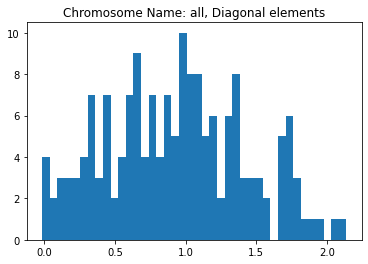

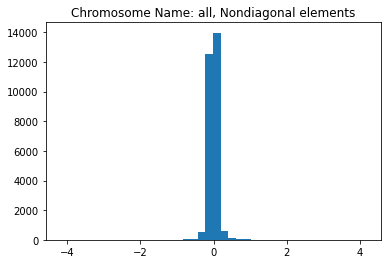

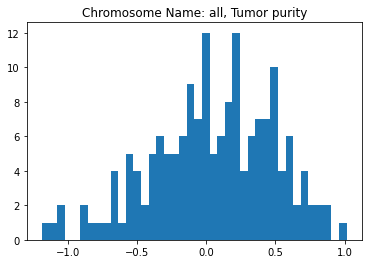

mask_name  masked_mse     ratio
0       aug    2.989832  0.009090
1       dug    6.463461  0.001249
2       adg    7.371036  0.002209
3       ddg    4.017697  0.010038
4       ang    0.663054  0.163692
5       dng    0.584110  0.175778
6       cna    0.837078  0.362055
7    noncna    0.831987  0.637945

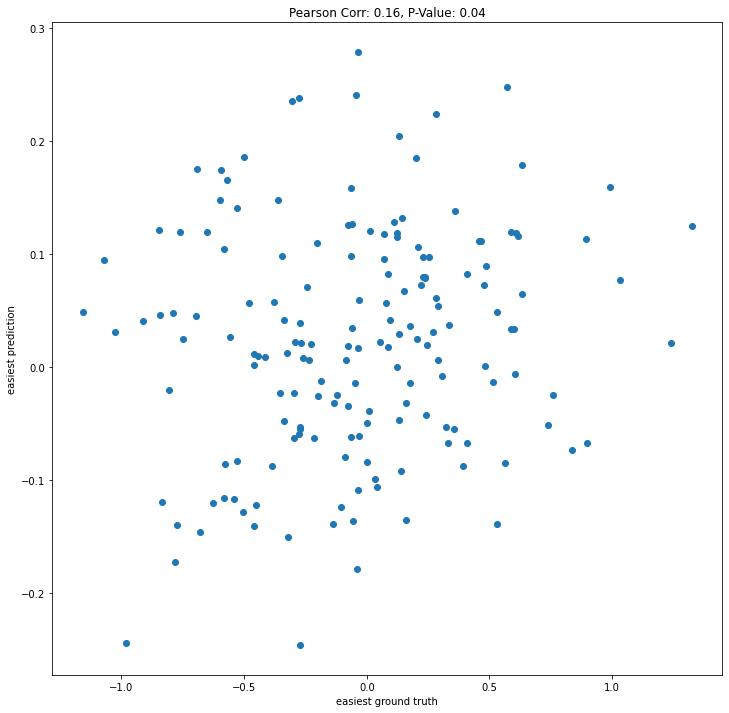

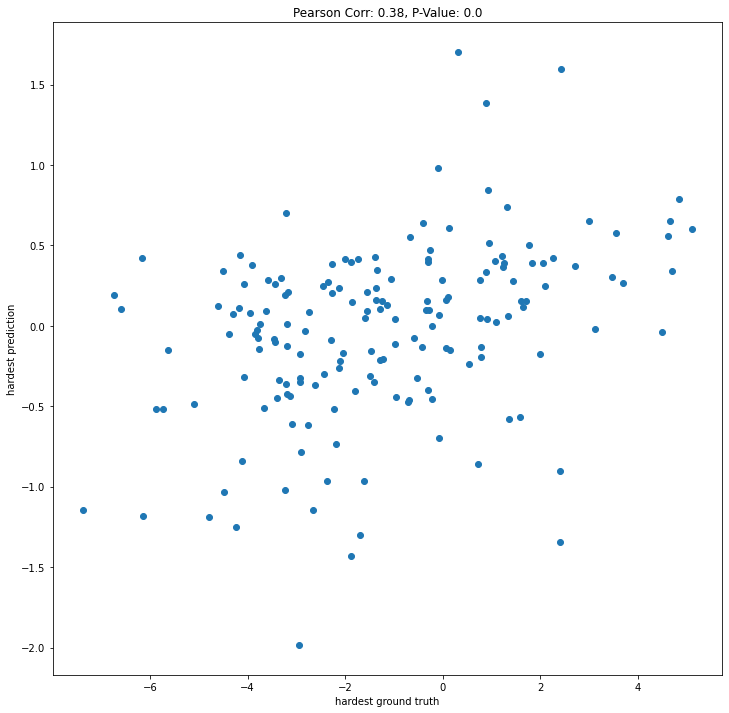

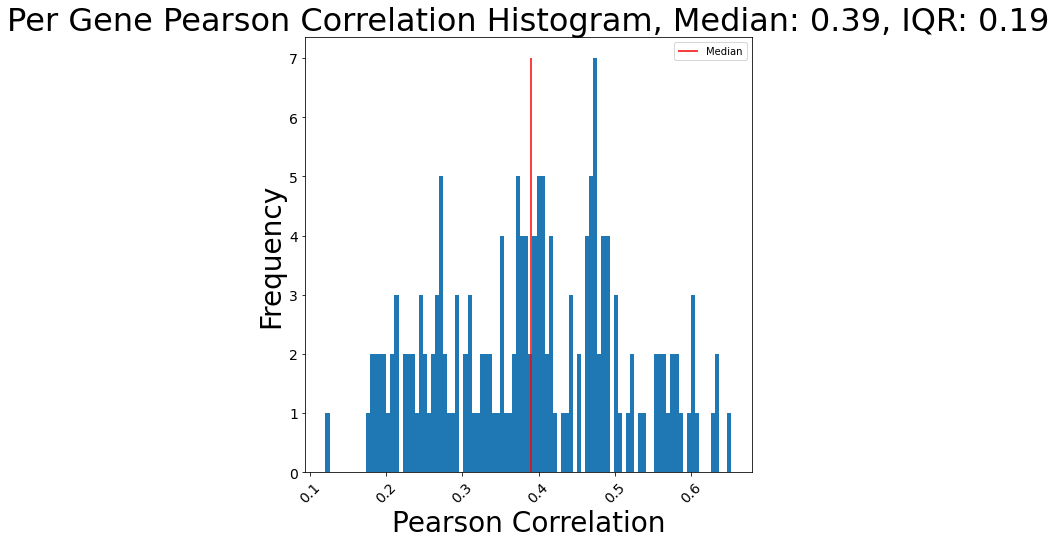

In [24]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcna2zscore",
         model_name="sklearn_linear",
         gene_type="rppa_genes",
         per_chromosome=False,
         regularization='l1')


In [25]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcna2zscore",
         model_name="sklearn_linear",
         gene_type="rppa_genes",
         per_chromosome=True,
         regularization='l1')


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'dict'

{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'rppa2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673690318_544bdccf64bc4867a9a1eb21bfe3ef1c',
    'gene_embedding_size': 0,
    'gene_type': 'rppa_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 197,
    'l1_reg_diagonal_coeff': 0.001,
    'l1_reg_nondiagonal_coeff': 0.001,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_per_gene',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 168,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 168,
    'per_chromosome': False,
    'processed_data_dir'

cancer_type   all_mse  all_corr  all_p_value
28         all  0.890135  0.314416          0.0

mask_name  masked_mse     ratio
0       aug    5.515041  0.009419
1       dug    5.194342  0.001254
2       adg    6.092570  0.002126
3       ddg    6.339050  0.009879
4       ang    0.713011  0.162467
5       dng    0.689309  0.171161
6       cna    1.032415  0.356306
7    noncna    0.811379  0.643694

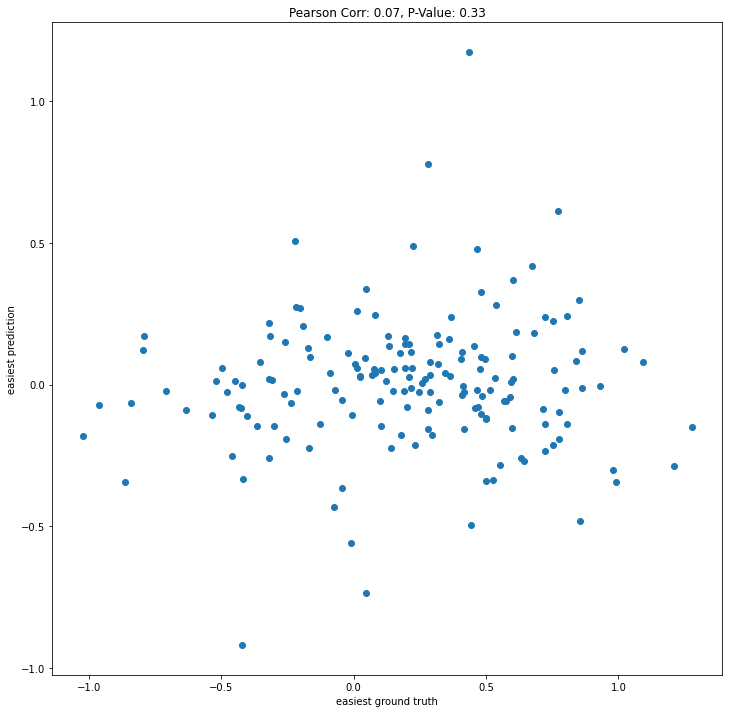

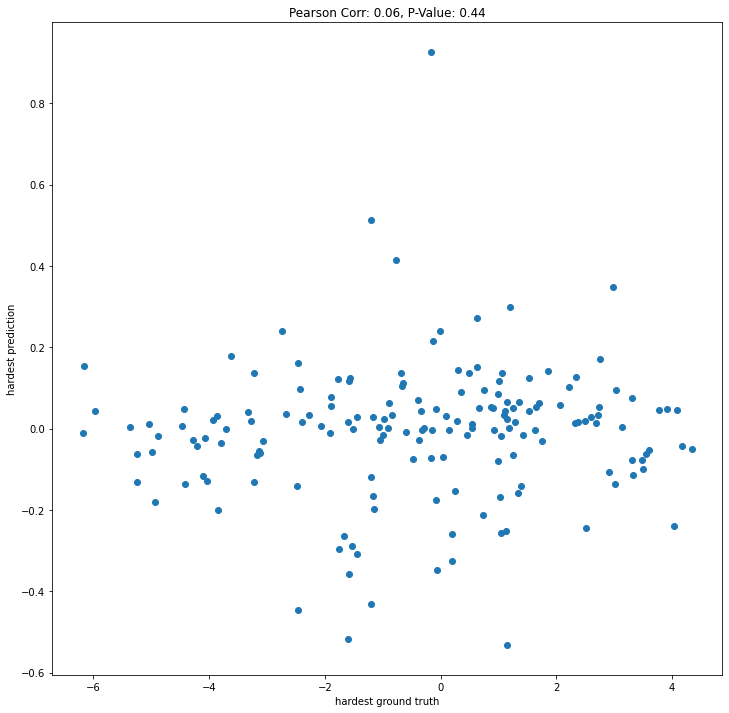

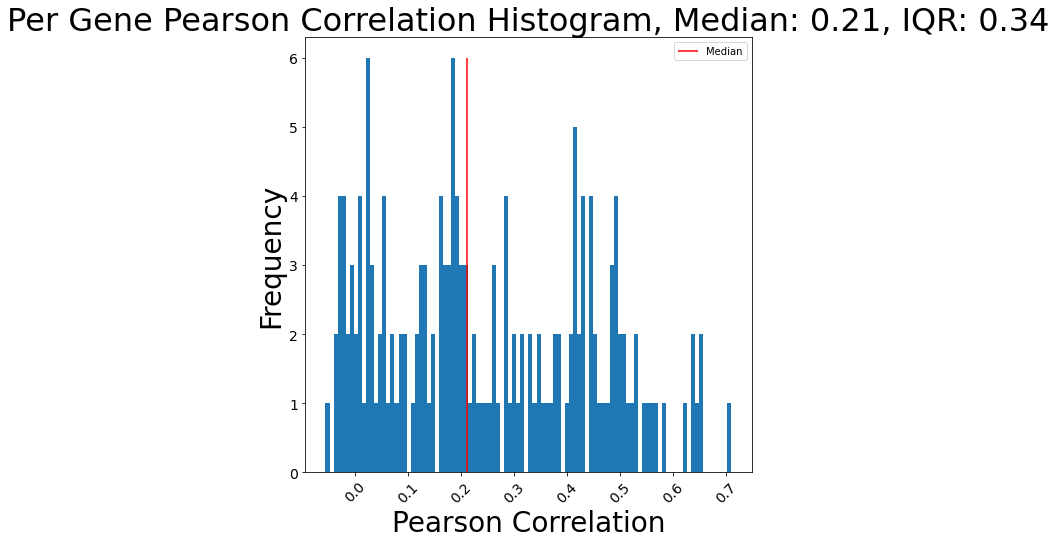

In [28]:
plot_all(experiment_cancer_type="all",
         dataset="rppa2zscore",
         model_name="sklearn_per_gene",
         gene_type="rppa_genes",
         per_chromosome=False,
         regularization='l1')


{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'rppa2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673690312_792d3364a077417cb4e4084a53a12b53',
    'gene_embedding_size': 0,
    'gene_type': 'rppa_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 197,
    'l1_reg_diagonal_coeff': 0.001,
    'l1_reg_nondiagonal_coeff': 0.001,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_linear',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 168,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 168,
    'per_chromosome': False,
    'processed_data_dir': 

cancer_type   all_mse  all_corr  all_p_value
28         all  0.752239  0.490756          0.0

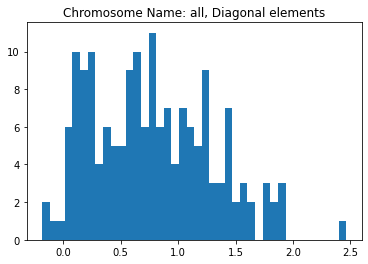

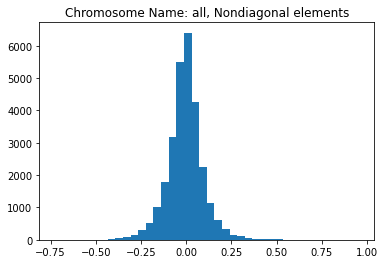

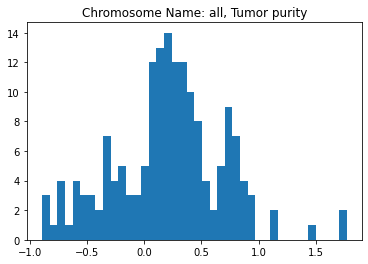

mask_name  masked_mse     ratio
0       aug    4.046238  0.009419
1       dug    4.020158  0.001254
2       adg    4.606225  0.002126
3       ddg    4.734048  0.009879
4       ang    0.620147  0.162467
5       dng    0.605706  0.171161
6       cna    0.853583  0.356306
7    noncna    0.696142  0.643694

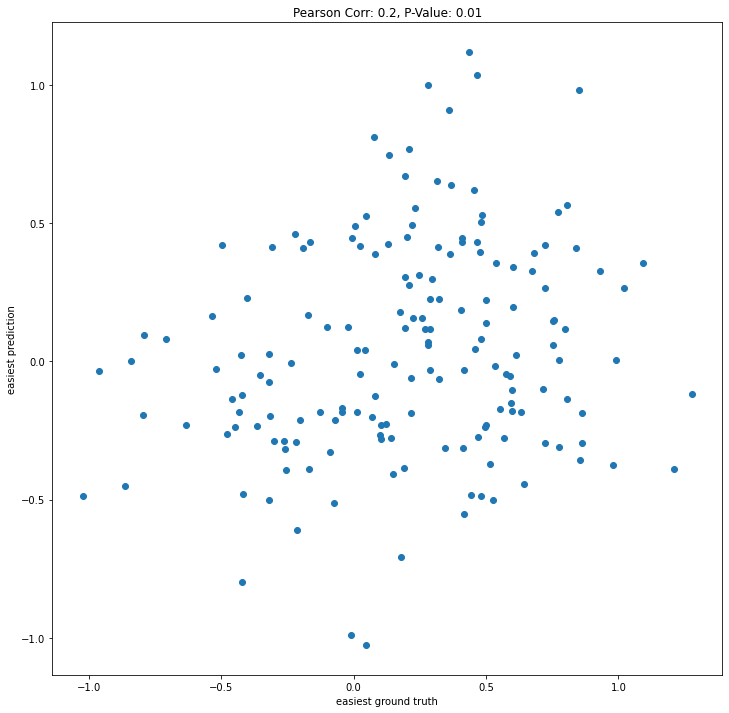

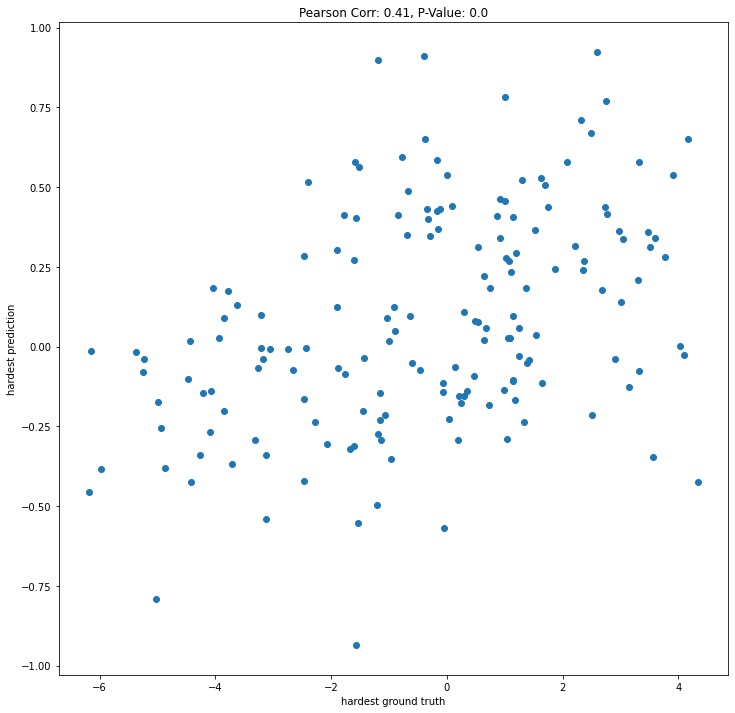

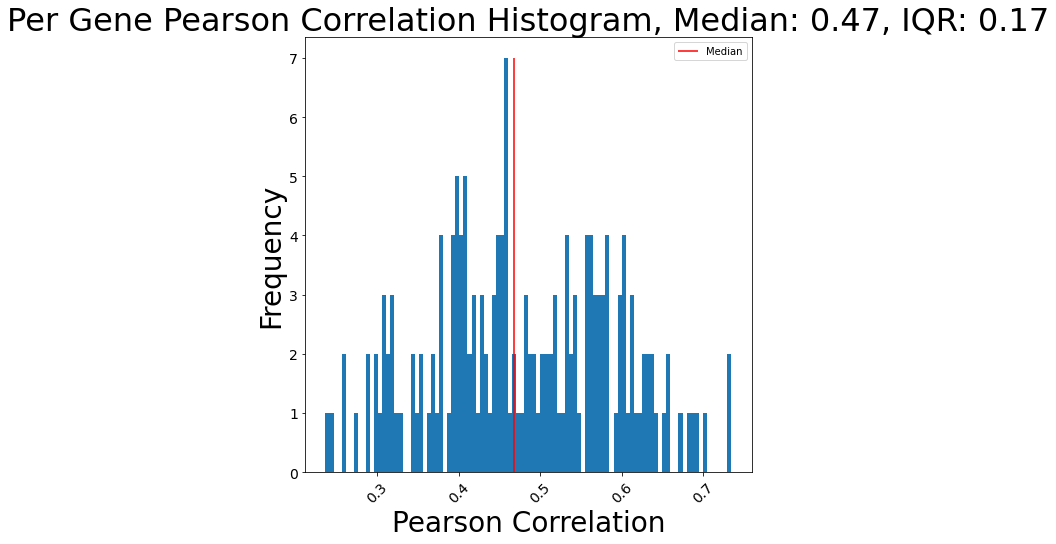

In [29]:
plot_all(experiment_cancer_type="all",
         dataset="rppa2zscore",
         model_name="sklearn_linear",
         gene_type="rppa_genes",
         per_chromosome=False,
         regularization='l1')


In [ ]:
plot_all(experiment_cancer_type="all",
         dataset="rppa2zscore",
         model_name="sklearn_linear",
         gene_type="rppa_genes",
         per_chromosome=True,
         regularization='l1')


{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'unthresholdedcnapurity2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673690324_04904c9b0f9f4c96939ff269f7ffa02d',
    'gene_embedding_size': 0,
    'gene_type': 'rppa_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 198,
    'l1_reg_diagonal_coeff': 0.001,
    'l1_reg_nondiagonal_coeff': 0.001,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_per_gene',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 168,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 168,
    'per_chromosome': False,
    'p

cancer_type   all_mse  all_corr  all_p_value
29         all  0.849908  0.380318          0.0

mask_name  masked_mse     ratio
0       aug    3.311891  0.009090
1       dug    7.066211  0.001249
2       adg    8.061435  0.002209
3       ddg    4.391592  0.010038
4       ang    0.658989  0.163692
5       dng    0.573144  0.175778
6       cna    0.854659  0.362055
7    noncna    0.847211  0.637945

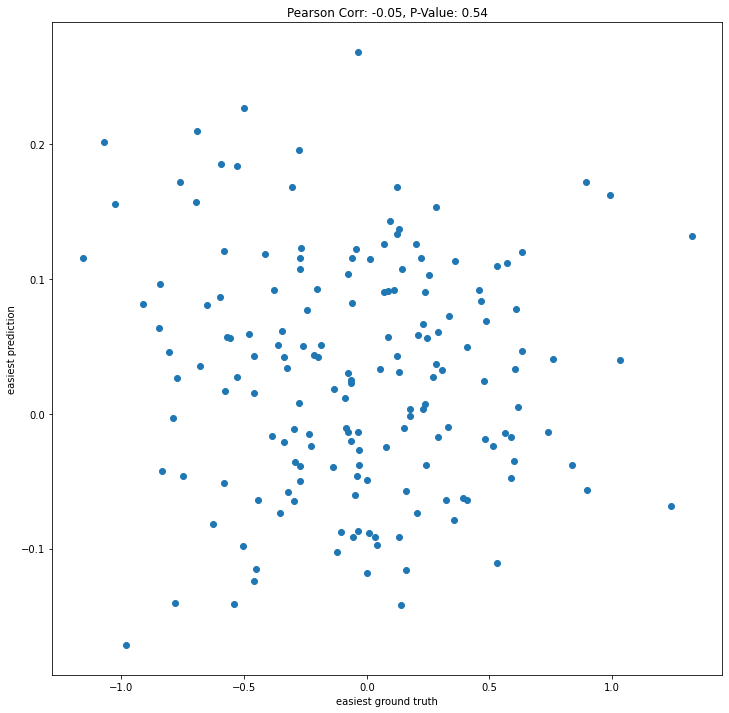

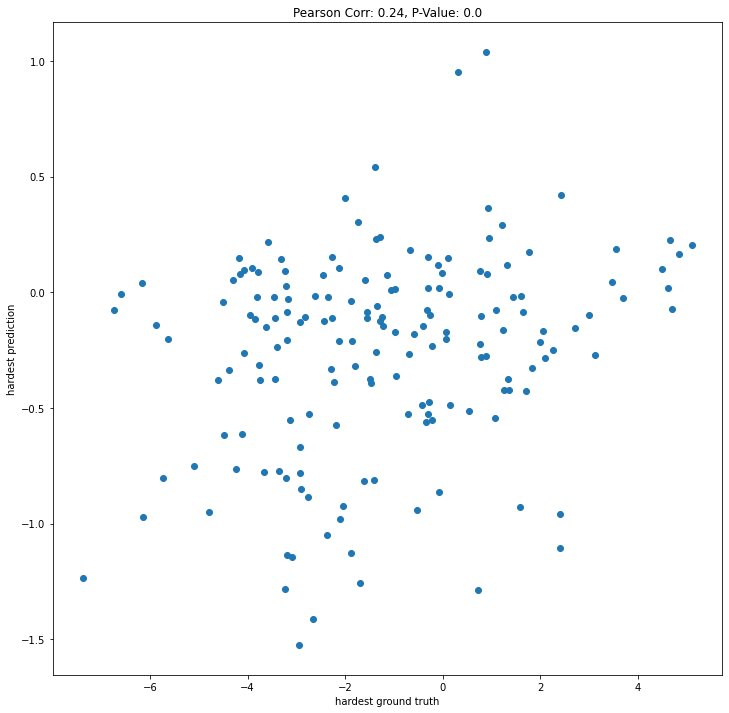

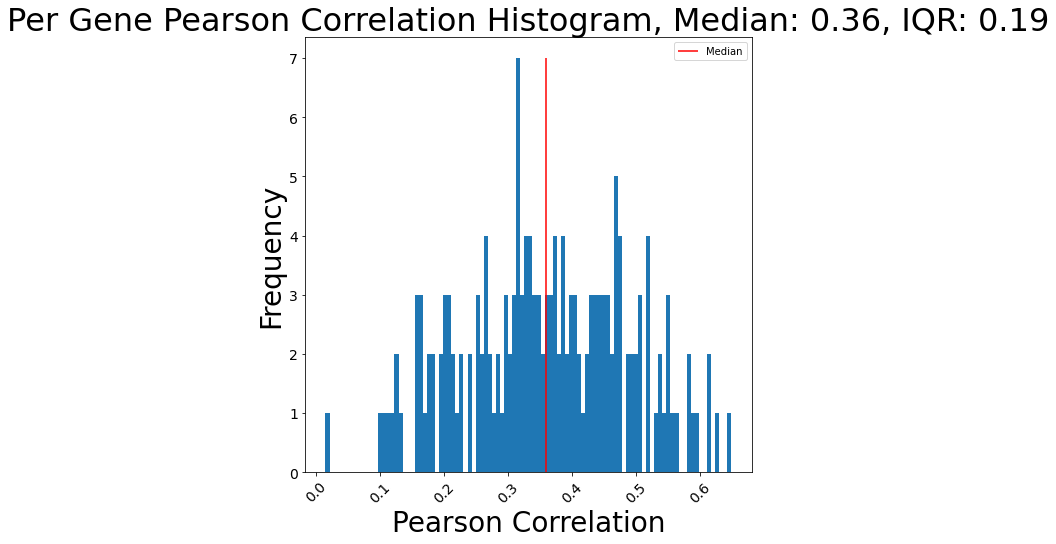

In [33]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcnapurity2zscore",
         model_name="sklearn_per_gene",
         gene_type="rppa_genes",
         per_chromosome=False,
         regularization='l1')


{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'unthresholdedcnapurity2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673694618_1d16b332bc5243378c5b1dc21a0e632f',
    'gene_embedding_size': 0,
    'gene_type': 'rppa_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 198,
    'l1_reg_diagonal_coeff': 0.01,
    'l1_reg_nondiagonal_coeff': 0.01,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_linear',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 168,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 168,
    'per_chromosome': False,
    'proce

cancer_type   all_mse  all_corr  all_p_value
29         all  0.804387  0.436402          0.0

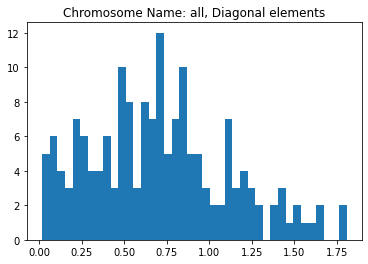

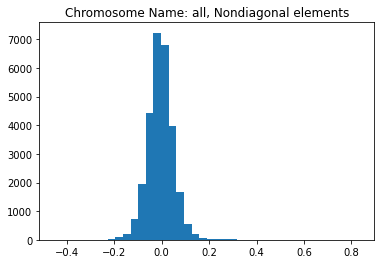

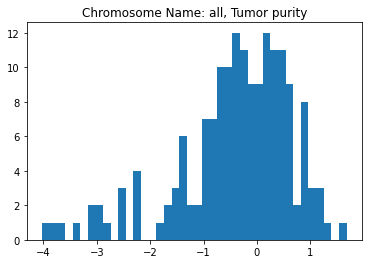

mask_name  masked_mse     ratio
0       aug    3.054089  0.009090
1       dug    6.277506  0.001249
2       adg    7.128821  0.002209
3       ddg    4.091327  0.010038
4       ang    0.622591  0.163692
5       dng    0.553255  0.175778
6       cna    0.805339  0.362055
7    noncna    0.803846  0.637945

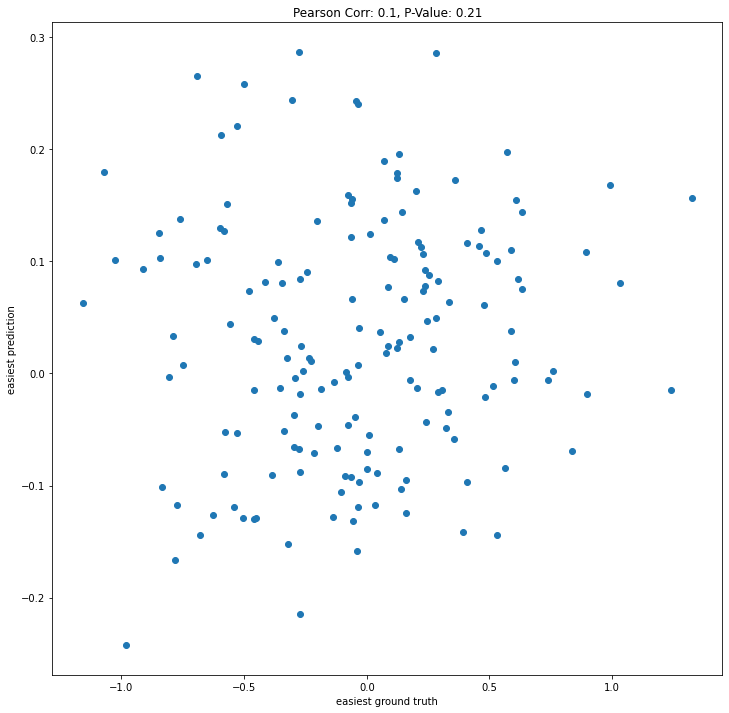

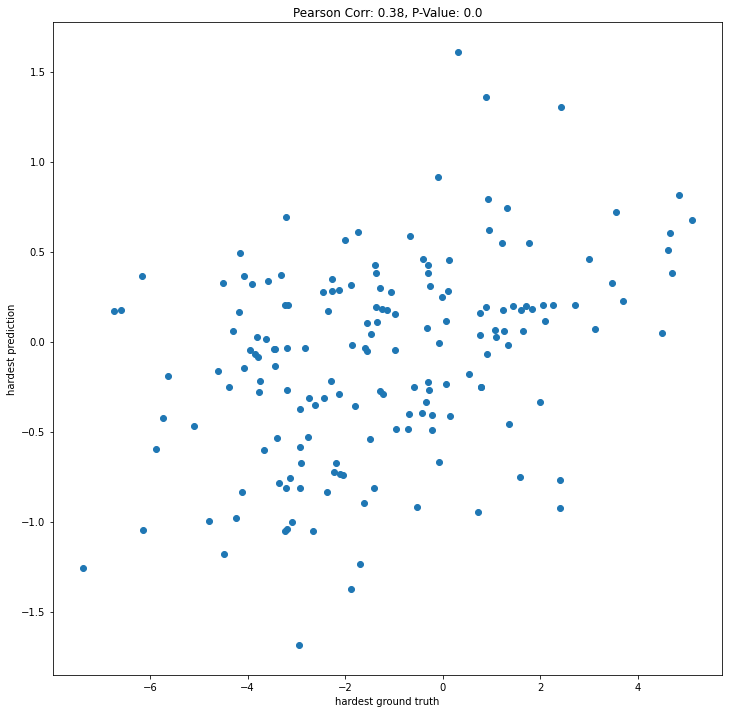

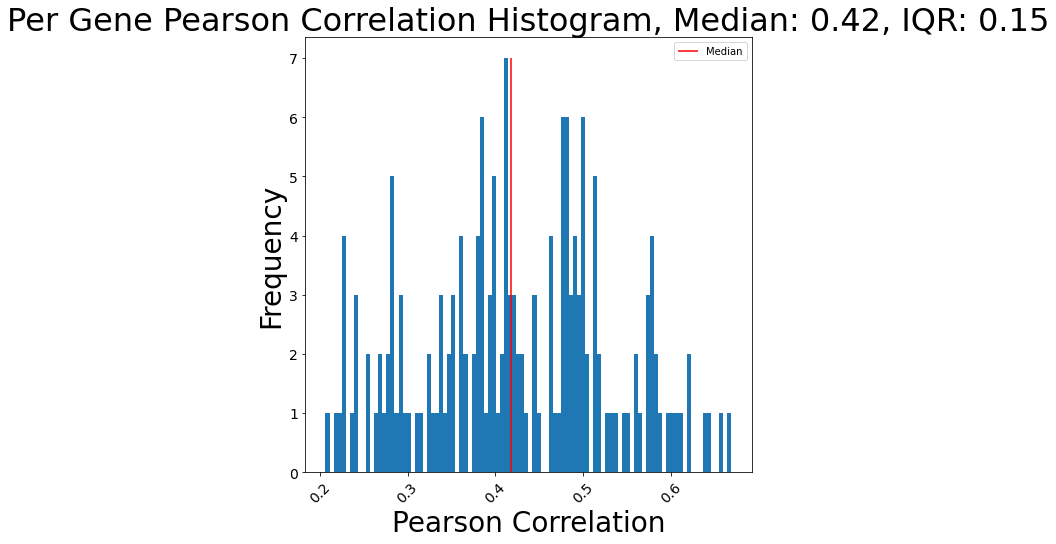

In [34]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcnapurity2zscore",
         model_name="sklearn_linear",
         gene_type="rppa_genes",
         per_chromosome=False,
         regularization='l1')


In [35]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcnapurity2zscore",
         model_name="sklearn_linear",
         gene_type="rppa_genes",
         per_chromosome=True,
         regularization='l1')


{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'unthresholdedcnapurity2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673699355_419788fe0caf46ae8630ae605568e784',
    'gene_embedding_size': 0,
    'gene_type': 'rppa_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 198,
    'l1_reg_diagonal_coeff': 0.001,
    'l1_reg_nondiagonal_coeff': 0.001,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_linear',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 168,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 168,
    'per_chromosome': True,
    'proc

cancer_type   all_mse  all_corr  all_p_value
29         all  0.847142  0.383942          0.0

NameError: name 'chromosome_namme' is not defined

In [ ]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcnapurity2zscore",
         model_name="sklearn_per_gene",
         gene_type="168_highly_expressed_genes",
         per_chromosome=False,
         regularization='l1')


{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'unthresholdedcnapurity2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673690317_763bd551a96b4101a06a814514f6e5e5',
    'gene_embedding_size': 0,
    'gene_type': '168_highly_expressed_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 198,
    'l1_reg_diagonal_coeff': 0.01,
    'l1_reg_nondiagonal_coeff': 0.01,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_linear',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 168,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 168,
    'per_chromosome': F

cancer_type   all_mse  all_corr  all_p_value
29         all  0.946708  0.175187          0.0

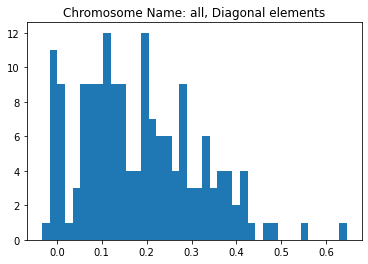

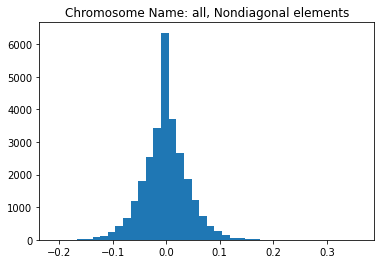

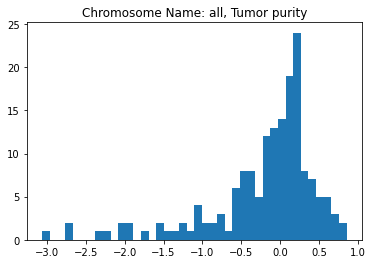

mask_name  masked_mse     ratio
0       aug    8.365218  0.009435
1       dug    9.618728  0.005325
2       adg    5.962349  0.000117
3       ddg    4.541560  0.000178
4       ang    0.643080  0.165895
5       dng    0.566653  0.166664
6       cna    0.957306  0.347613
7    noncna    0.941062  0.652387

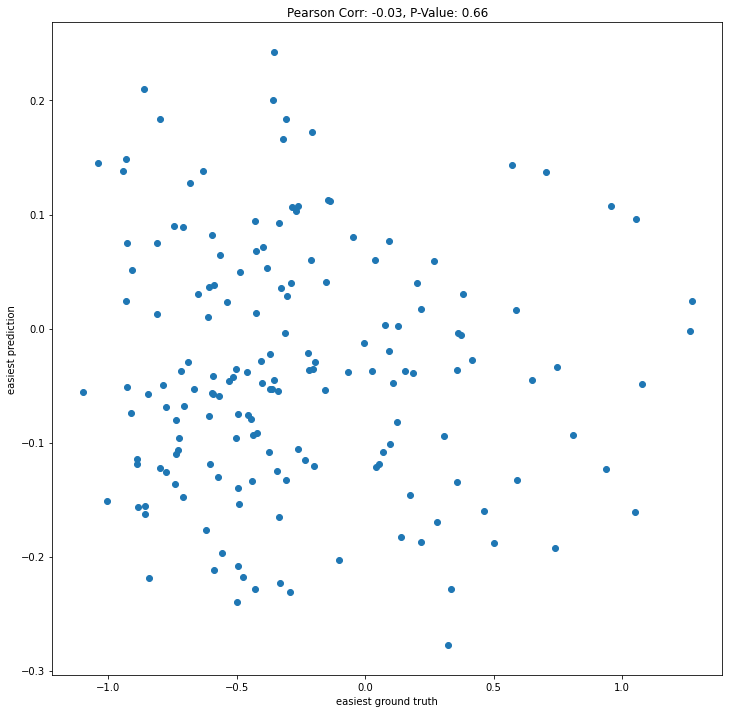

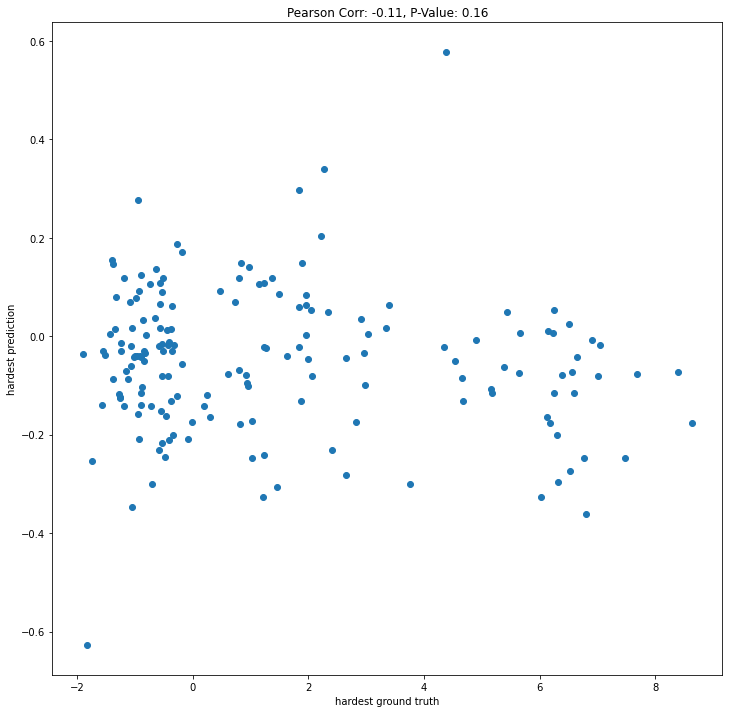

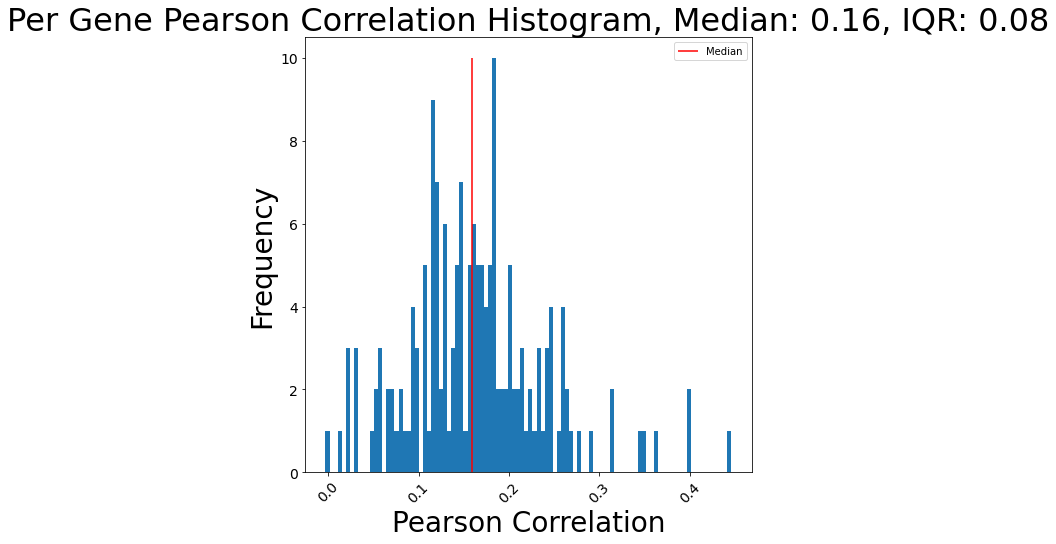

In [26]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcnapurity2zscore",
         model_name="sklearn_linear",
         gene_type="168_highly_expressed_genes",
         per_chromosome=False,
         regularization='l1')


In [27]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcnapurity2zscore",
         model_name="sklearn_linear",
         gene_type="168_highly_expressed_genes",
         per_chromosome=True,
         regularization='l1')


{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'unthresholdedcnapurity2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673697326_414e59a8fe784af5b17acb3c9a6a4d6d',
    'gene_embedding_size': 0,
    'gene_type': '168_highly_expressed_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 198,
    'l1_reg_diagonal_coeff': 0.01,
    'l1_reg_nondiagonal_coeff': 0.01,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_linear',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 168,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 168,
    'per_chromosome': T

cancer_type   all_mse  all_corr  all_p_value
29         all  0.957791  0.135867          0.0

NameError: name 'chromosome_namme' is not defined

{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'unthresholdedcnapurity2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673690317_c05658db8b164605bcea720af5cc2b0c',
    'gene_embedding_size': 0,
    'gene_type': '1000_highly_expressed_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 1027,
    'l1_reg_diagonal_coeff': 0.01,
    'l1_reg_nondiagonal_coeff': 0.01,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_per_gene',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 997,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 997,
    'per_chromosome

cancer_type   all_mse  all_corr  all_p_value
29         all  0.958268   0.15362          0.0

mask_name  masked_mse     ratio
0       aug    8.141078  0.008449
1       dug    8.902413  0.005224
2       adg    6.108585  0.000562
3       ddg    4.974931  0.000962
4       ang    0.676246  0.163808
5       dng    0.627455  0.174578
6       cna    0.972388  0.353583
7    noncna    0.950545  0.646417

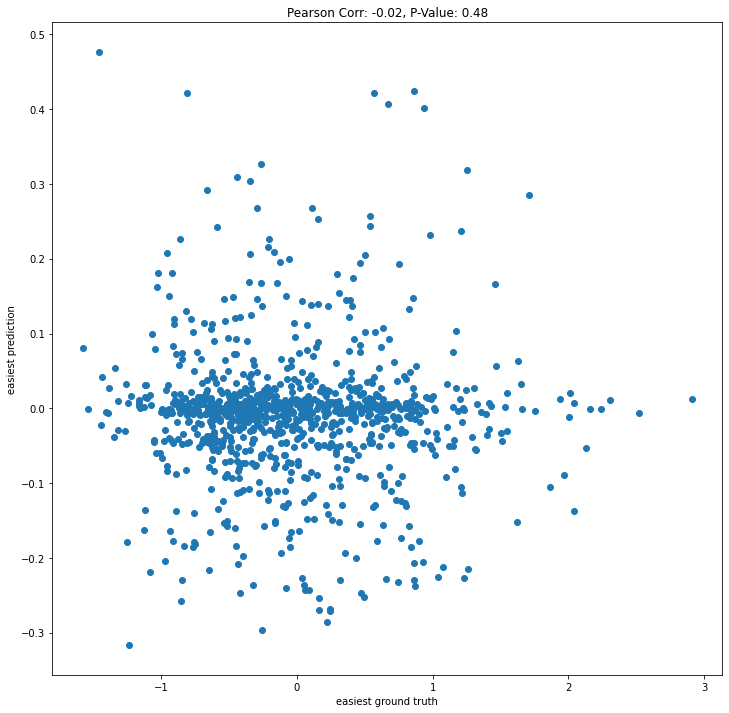

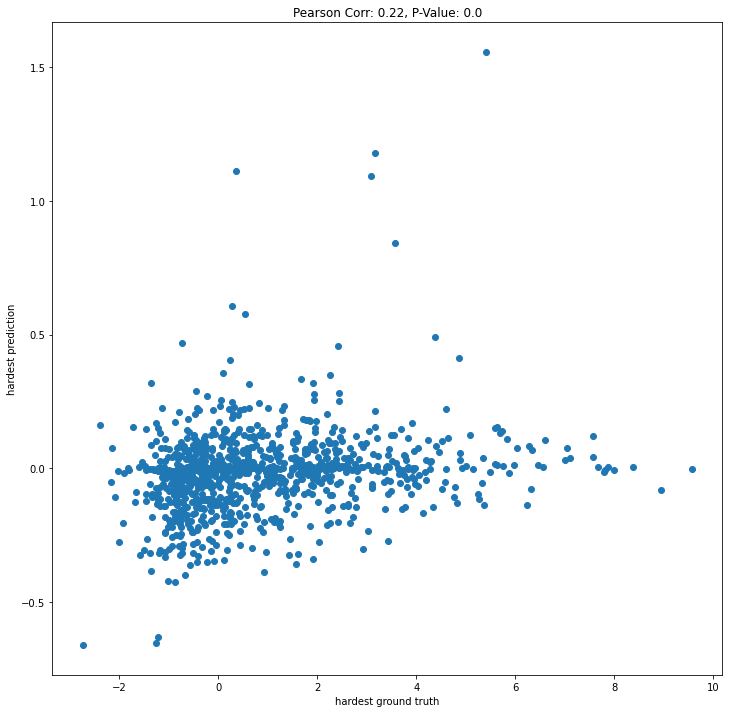

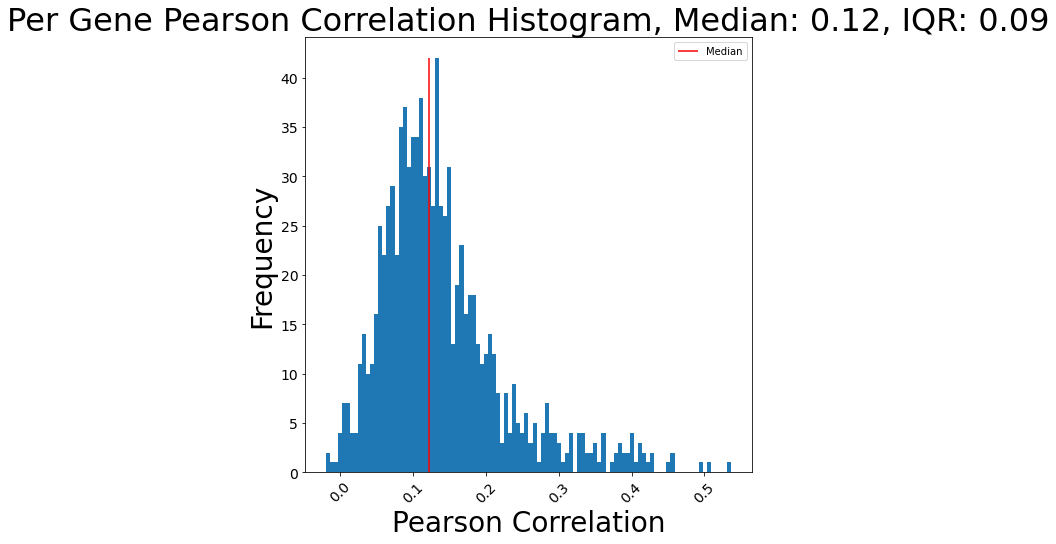

In [30]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcnapurity2zscore",
         model_name="sklearn_per_gene",
         gene_type="1000_highly_expressed_genes",
         per_chromosome=False,
         regularization='l1')


In [31]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcnapurity2zscore",
         model_name="sklearn_linear",
         gene_type="1000_highly_expressed_genes",
         per_chromosome=False,
         regularization='l1')


TypeError: join() argument must be str, bytes, or os.PathLike object, not 'dict'

In [32]:
plot_all(experiment_cancer_type="all",
         dataset="unthresholdedcnapurity2zscore",
         model_name="sklearn_linear",
         gene_type="1000_highly_expressed_genes",
         per_chromosome=True,
         regularization='l1')


{   'batch_size': 32,
    'cancer_type': 'all',
    'checkpoints_dir': '/cluster/scratch/aarslan/cna2zscore_checkpoints',
    'dataset': 'unthresholdedcnapurity2zscore',
    'device': 'cpu',
    'dropout': 0.0,
    'early_stopping_patience': 8,
    'experiment_name': '1673698505_f17625a9bac543e4a6e8272de2aca501',
    'gene_embedding_size': 0,
    'gene_type': '1000_highly_expressed_genes',
    'gradient_norm': 10.0,
    'hidden_activation': 'relu',
    'hidden_dimension_ratio': 0.0,
    'input_dimension': 1027,
    'l1_reg_diagonal_coeff': 0.01,
    'l1_reg_nondiagonal_coeff': 0.01,
    'l2_reg_diagonal_coeff': 0.0,
    'l2_reg_nondiagonal_coeff': 0.0,
    'learning_rate': 0.0,
    'log_level': 'info',
    'loss_function': 'mse',
    'min_lr': 2.5e-05,
    'model': 'sklearn_linear',
    'num_attention_heads': 0,
    'num_epochs': 200,
    'num_genes': 997,
    'num_mlp_blocks': 4,
    'num_nonlinear_layers': 0,
    'optimizer': 'adam',
    'output_dimension': 997,
    'per_chromosome':

cancer_type  all_mse  all_corr  all_p_value
29         all  0.95118  0.172543          0.0

NameError: name 'chromosome_namme' is not defined